# 1 Packages

In [1]:
using PyPlot            ; println("geladen: PyPlot")
using PyCall            ; println("geladen: PyCall")
using Colors            ; println("geladen: Colors")
using Dates             ; println("geladen: Dates")
using CSV               ; println("geladen: CSV")
using DataFrames        ; println("geladen: DataFrames")
using ProgressMeter     ; println("geladen: ProgressMeter")
using InteractiveUtils  ; println("geladen: InteractiveUtils")
using Statistics        ; println("geladen: Statistics")
using LinearAlgebra     ; println("geladen: LinearAlgebra")
using Images            ; println("geladen: Images")
using ImageSegmentation ; println("geladen: ImageSegmentation")
using Base.Iterators    ; println("geladen: Base.Iterators")
#using Interpolations   ; println("Interpolations geladen")

@pyimport matplotlib.colors as mcolors ; println("importiert: matplotlib.colors as mcolors")
@pyimport matplotlib.ticker as ticker  ; println("importiert: matplotlib.ticker as ticker")
println("done")
#npt - inputs
#oup - outputs
#pth - paths
#ctp - control parameters   #inpt #outp #pths #clpr

geladen: PyPlot
geladen: PyCall
geladen: Colors
geladen: Dates
geladen: CSV
geladen: DataFrames
geladen: ProgressMeter
geladen: InteractiveUtils
geladen: Statistics
geladen: LinearAlgebra
geladen: Images
geladen: ImageSegmentation
geladen: Base.Iterators
importiert: matplotlib.colors as mcolors
importiert: matplotlib.ticker as ticker
done


# 2 Grundlegende Funktionen

In [2]:
# Grundlegende Funktionen
########################################################################################
function Zeitentw_Funk(oup, npt)

    ####################################################################################
    ### Variablen und Kontrollparameter initialisieren
    ####################################################################################

    last_t_Index           = Int64(round(npt[:t_end]/npt[:t_step_sim]))
    n_t_steps_per_sim_unit = Int64(round(npt[:t_step_plot] / npt[:t_step_sim]))
    n_t_steps_reaction     = Int64(round(npt[:τ_reaction] / npt[:t_step_sim]))
    
    n_t_steps_oa_delay     = Int64(round(npt[:τ_oa_delay] / npt[:t_step_sim]))
    
    
    println("npt[:τ_reaction] = $npt[:τ_reaction] , n_t_steps_reaction = $n_t_steps_reaction")

    #################################################################################
    ### Anfagszustand initialisieren
    #################################################################################
    initial_distance = npt[:L_track] / npt[:N_cars]
    first_car_loc    = npt[:L_track] - initial_distance
    println("first_car_loc = $first_car_loc")
    println("initial_distance = $initial_distance")

    #############################################################
    ### initial-acceleration berechnen
    #############################################################
    #x_init_accel_vec = [0, initial_distance]
    #v_init_accel_vec = [npt[:v_init], npt[:v_init]]
    
    #:over_accel_vec_in => [],#   :τ_oa_delay
    
    for _2 in 1 : npt[:N_cars]
        push!(oup[:accel_vec_in], Any[0.0 for _ in 1:n_t_steps_reaction])
        push!(oup[:over_accel_cp_vec], 0.0)
        
        push!(oup[:over_accel_vec_in], Any[0.0 for _ in 1:n_t_steps_oa_delay])
    end
    
    if npt[:monitoring_oa_switch] == 1
        oup[:cpara_monitoring_oa] = [[] for _ in 1 : npt[:N_cars]]
        oup[:accel_monitoring_oa] = [[] for _ in 1 : npt[:N_cars]]
    end
    
    #############################################################
    ### Startwerte einsetzen: v, s, g, vehicle_n_vector
    #############################################################
    push!(oup[:t_vec_in], 0)
    
    for index_initials in 1 : npt[:N_cars] # index_initials = 0 => Phantomauto
        insert!(oup[:s_vec_in][1],     1, npt[:L_track] - index_initials * initial_distance)
        #insert!(oup[:v_vec_in][1],     1, (3/4 + 1/4 * rand()) * npt[:v_init])
        #insert!(oup[:v_vec_in][1],     1, (1 - npt[:init_noise] + npt[:init_noise] * rand()) * npt[:v_init])
        insert!(oup[:v_vec_in][1],     1, (1 - npt[:init_noise] * rand()) * npt[:v_init])
        insert!(oup[:g_vec_in][1],     1, initial_distance - npt[:d_par]) # neu 6.6.2024 Peter Lustig
    end #f48
    ####################################################################################
    ### Zeitentwicklung durchführen
    ####################################################################################
    for t_Index in 1 : last_t_Index #t_first_in_unit : t_last_in_unit
        
        time      = round(t_Index*npt[:t_step_sim], digits = 2)
        t_ArIndex = length(oup[:s_vec_in]) + 1# neu 9.7.2024
        push!(oup[:t_vec_in]    , time)
        push!(oup[:s_vec_in]    , deepcopy(oup[:s_vec_in][t_ArIndex - 1]))
        push!(oup[:v_vec_in]    , deepcopy(oup[:v_vec_in][t_ArIndex - 1]))
        push!(oup[:g_vec_in]    , deepcopy(oup[:g_vec_in][t_ArIndex - 1]))
        #push!(oup[:s_vec_in] , []); push!(oup[:s_vec_in][t_ArIndex] , deepcopy(oup[:s_vec_in][t_ArIndex - 1]))
        #push!(oup[:v_vec_in] , []); push!(oup[:v_vec_in][t_ArIndex] , deepcopy(oup[:v_vec_in][t_ArIndex - 1]))
        #push!(oup[:g_vec_in] , []); push!(oup[:g_vec_in][t_ArIndex] , deepcopy(oup[:g_vec_in][t_ArIndex - 1]))

        ######################################################################################################
        ### neue Beschleunigung berechnen
        ######################################################################################################
        oup = new_accel_func(oup, npt, t_ArIndex - 1)
        
        # a_values(t) = f(s_values(t), v_values(t))
        # v(t+1) = v(t) + a(t) * Δt
        # v(t+1) = v(t) + a(t) * Δt
        #######################################################################################################
        ### neue Geschwindigkeit berechnen
        #######################################################################################################
        for pos_Index in 1 : npt[:N_cars] #length(oup[:s_vec_in][t_ArIndex - 1])

            over_acceleration = oup[:over_accel_vec_in][pos_Index][1]
            # Die Beschleunigungsleistung des Motors ist durch a_max limitiert!
            acceleration = min(oup[:accel_vec_in][pos_Index][1] + oup[:over_accel_vec_in][pos_Index][1] , npt[:a_max])
            
            if (npt[:monitoring_oa_switch] == 1 && time ≤ npt[:monitoring_oa_duration])
                push!(oup[:accel_monitoring_oa][pos_Index] , acceleration)
            end

            vel     = oup[:v_vec_in][t_ArIndex - 1][pos_Index] + npt[:t_step_sim] * acceleration
            
            if npt[:oa_in_fflow_switch] == 1 && over_acceleration > 0
                ## monitoring der acceleration inklusive over-acceleration
                vel_cor = max(npt[:v_min] , min(vel , npt[:v_max_exception])) # Maximum:140 km/h !!!!
    
            elseif (npt[:oa_in_fflow_switch] == 1 && over_acceleration == 0 &&
                    oup[:v_vec_in][t_ArIndex - 1][pos_Index] > npt[:v_max])
                #vel_cor = max(npt[:v_min] , min(vel , npt[:v_max]))
                vel_cor = max(npt[:v_min] , min(vel , npt[:v_max_exception])) # Peter Lustig 20.7.2024

            else #wenn npt[:oa_in_fflow_switch]==1 bzw. wenn(npt[:oa_in_fflow_switch]==0, oa==0 und v≤v_max)
                vel_cor = max(npt[:v_min] , min(vel , npt[:v_max])) # Maximum:120 km/h !!!!
                # Hier könnte man noch die tatsächliche Beschleunigung berechnen, indem man 
                # (v[t_ArIndex]-v[t_ArIndex-1])/npt[:t_step_sim] berechnet.
            end
            
            oup[:v_vec_in][t_ArIndex][pos_Index] = vel_cor
        end #f110
        
        ######################################################################################################
        ### neuen Ort berechnen
        ######################################################################################################
        for pos_Index in 1 : npt[:N_cars] #length(oup[:s_vec_in][t_ArIndex - 1])
            loc = oup[:s_vec_in][t_ArIndex - 1][pos_Index] + (
                  oup[:v_vec_in][t_ArIndex - 1][pos_Index] * npt[:t_step_sim])
            oup[:s_vec_in][t_ArIndex][pos_Index] = loc
        end #f118
        
        # Export-Variablen befüllen
        if mod(t_Index , n_t_steps_per_sim_unit) == 0
             # length(oup[:t_vec_in])
            push!(oup[:t_vec_ex] , oup[:t_vec_in][t_ArIndex])
            push!(oup[:s_vec_ex] , oup[:s_vec_in][t_ArIndex])
            push!(oup[:v_vec_ex] , oup[:v_vec_in][t_ArIndex])
            push!(oup[:g_vec_ex] , 
                (t_Index == last_t_Index ? oup[:g_vec_in][t_ArIndex - 1] : oup[:g_vec_in][t_ArIndex]))
        end

        oup[:gmin] = min(oup[:gmin] , minimum(oup[:g_vec_in][t_ArIndex - 1]))
        oup[:gmax] = max(oup[:gmax] , maximum(oup[:g_vec_in][t_ArIndex - 1]))
        
        oup[:vmin] = min(oup[:vmin] , minimum(oup[:v_vec_in][t_ArIndex - 1]))
        oup[:vmax] = max(oup[:vmax] , maximum(oup[:v_vec_in][t_ArIndex - 1]))

       
        #push!(oup[:g_sum_vec] , sum(oup[:g_vec_in][t_ArIndex]) + (npt[:N_cars] * npt[:d_par]))
        push!(oup[:g_mean_vec] , mean(oup[:g_vec_in][t_ArIndex]))
        push!(oup[:v_mean_vec] , mean(oup[:v_vec_in][t_ArIndex]))
        
        if t_Index ≥ n_t_steps_per_sim_unit + 1
            # + 1 hinzugefpgt, um alle oup[:g_vec_in] Werte in potential_oup[:gmin]_vec auszuwerten
            deleteat!(oup[:t_vec_in] , 1)
            deleteat!(oup[:s_vec_in] , 1)
            deleteat!(oup[:v_vec_in] , 1)
            deleteat!(oup[:g_vec_in] , 1)
        end
        
    end #f78 Zeitschleife

    oup[:t_vec_in]     = []
    oup[:s_vec_in]     = [[]]
    oup[:v_vec_in]     = [[]]
    oup[:g_vec_in]     = [[]]
    oup[:accel_vec_in] = []
    println("\n"*"oup[:list_yet_monitored_cars_acc] = $(oup[:list_yet_monitored_cars_acc])\n")
    return oup
end

#######################################################################################################


# Maxima und Minima der Orte der Positions-Indizes (inklusive der jeweils folgenden Position)
# t-schrittweise aktualisieren
####################################################################################################
function heaviside(x)
    if x ≥ 0
        return 1
    elseif x < 0
        return 0
    else return NaN
    end
end

##########################################################################
### Beschleunigungsfunktionen
##########################################################################
function new_accel_func(oup_v, npt_v, t_ArIndex2) # früher: new_accel_func_s2

    for pos in 1 : npt_v[:N_cars]

        #pos        = oup_v[:veh_n_vec_in][t_ArIndex2][pos]
        acceleration      = 0.0
        over_acceleration = 0.0
        
        x_val   = oup_v[:s_vec_in][t_ArIndex2][pos]
        x_l_val = (pos < npt_v[:N_cars] ? oup_v[:s_vec_in][t_ArIndex2][pos + 1] :
            oup_v[:s_vec_in][t_ArIndex2][1] + npt_v[:L_track])
        v_val   = oup_v[:v_vec_in][t_ArIndex2][pos]
        v_l_val = (pos < npt_v[:N_cars] ? oup_v[:v_vec_in][t_ArIndex2][pos + 1] :
            oup_v[:v_vec_in][t_ArIndex2][1])
        g_H     = x_l_val - x_val - npt_v[:d_par]

        # Verkehrsphase bestimmen
        traffic_phase = get_traffic_phase_func(npt_v, g_H, v_val)

        # jam
        if traffic_phase == "J"
            g_safe       = v_val * npt_v[:τ_safe]
            acceleration = min(npt_v[:p1] * (g_H - g_safe) + npt_v[:p2] * (v_l_val - v_val) , npt_v[:a_max])
        # Synchro
        elseif traffic_phase == "S"
            acceleration = min(npt_v[:p3] * (v_l_val - v_val) + npt_v[:p4] * heaviside(v_val - npt_v[:v_syn]),
                npt_v[:a_max])
            if rand() < npt_v[:w1]
                oup_v[:over_accel_cp_vec][pos] += npt_v[:τ_over_acc]
            end
        # free flow
        else # das deckt τ_H > npt_v[:τ_G] bzw. traffic_phase == "F" ab.
            acceleration = npt_v[:a_max]
            if rand() < npt_v[:oa_in_fflow_switch] * npt_v[:w1] # hier ist der oa-in-ff-Schalter
                oup_v[:over_accel_cp_vec][pos] += npt_v[:τ_over_acc]
            end
        end

        if oup_v[:over_accel_cp_vec][pos] > 0
            over_acceleration += npt_v[:p5]
            oup_v[:over_accel_cp_vec][pos] -= npt_v[:t_step_sim]
        end

        # Beschleunigungsvektor aktualisieren
        push!(    oup_v[:accel_vec_in][pos]    , acceleration)
        deleteat!(oup_v[:accel_vec_in][pos]    , 1)

        # Over-acceleration-Vektor aktualisieren
        push!(    oup_v[:over_accel_vec_in][pos] , over_acceleration)
        deleteat!(oup_v[:over_accel_vec_in][pos] , 1)

        # Monitoring-Werte speichern
        if (npt_v[:monitoring_oa_switch] == 1 &&
            npt_v[:monitoring_oa_first_car] ≤ pos ≤ oup_v[:N_initial_occupation] && 
            oup_v[:time] ≤ npt_v[:monitoring_oa_duration])
            push!(oup_v[:cpara_monitoring_oa][pos] , oup_v[:over_accel_cp_vec][pos])
        end

        # g (Spatial-Headway) speichern
        oup_v[:g_vec_in][t_ArIndex2][pos] = g_H

        if (npt_v[:monitoring_oa_switch] == 1 && over_acceleration > 0 &&
            !(pos in oup_v[:list_yet_monitored_cars_acc]))
            push!(oup_v[:list_yet_monitored_cars_acc] , pos)
        end
    end
    return oup_v
end # Ende Definition new_accel_func
#######################################################################################
# Verkehrsphase bestimmen
function get_traffic_phase_func(npt_v, g_H, v_val_v)
    traffic_phase_v = 0
    if npt_v[:acc_fct_nr] == 1
        if g_H < npt_v[:τ_safe] * v_val_v
            traffic_phase_v = "J"
        elseif npt_v[:τ_safe] * v_val_v < g_H < npt_v[:τ_G] * v_val_v
            traffic_phase_v = "S"
        else # npt_v[:τ_G] * v_val < g_H
            traffic_phase_v = "F"
        end
    else # npt[:acc_fct_nr] == 2
        τ_H = g_H / v_val_v
        if τ_H < npt_v[:τ_safe]
            traffic_phase_v = "J"
        elseif npt_v[:τ_safe] < τ_H < npt_v[:τ_G]
            traffic_phase_v = "S"
        else # npt_v[:τ_G] < τ_H
            traffic_phase_v = "F"
        end
    end
    return traffic_phase_v
end
############################################################################
### Daten für den Color-Plot vorbereiten
#############################################################################
function create_plot_vals_func5(;oup_v, t_in, t_ou, s_in, s_ou, z1_in, z1_ou, z2_in, z2_ou, z3_in, z3_ou)
    
    len_t_vals = length(oup_v[Symbol(z1_in)])
    
    for t_index in 1 : len_t_vals
        
        cars_on_track = length(oup_v[Symbol(z1_in)][t_index])

        for pos_index in 1 : (cars_on_track - 1)
            push!(oup_v[Symbol(t_ou) ] , oup_v[Symbol(t_in) ][t_index])            # t_vals
            push!(oup_v[Symbol(s_ou) ] , oup_v[Symbol(s_in) ][t_index][pos_index]) # s_vals
            push!(oup_v[Symbol(z1_ou)] , oup_v[Symbol(z1_in)][t_index][pos_index]) # v_vals
            push!(oup_v[Symbol(z2_ou)] , oup_v[Symbol(z2_in)][t_index][pos_index]) # g_vals
            push!(oup_v[Symbol(z3_ou)] , oup_v[Symbol(z3_in)][t_index][pos_index]) # τ_H_vals
        end
    end
end
############################################################################################################
function create_plot_vals_func6_one_car_test(;oup_v, t_in, t_ou, s_in, s_ou, z1_in, z1_ou, z2_in, z2_ou, z3_in, z3_ou)
    
    len_t_vals = length(oup_v[Symbol(z1_in)])
    
    for t_index in 1 : len_t_vals
        
        cars_on_track = length(oup_v[Symbol(z1_in)][t_index])

        for pos_index in 1 : cars_on_track # Hier geändert !!!!!
            push!(oup_v[Symbol(t_ou) ] , oup_v[Symbol(t_in) ][t_index])            # t_vals
            push!(oup_v[Symbol(s_ou) ] , oup_v[Symbol(s_in) ][t_index][pos_index]) # s_vals
            push!(oup_v[Symbol(z1_ou)] , oup_v[Symbol(z1_in)][t_index][pos_index]) # v_vals
            push!(oup_v[Symbol(z2_ou)] , oup_v[Symbol(z2_in)][t_index][pos_index]) # g_vals
            push!(oup_v[Symbol(z3_ou)] , oup_v[Symbol(z3_in)][t_index][pos_index]) # τ_H_vals
        end
    end
end
############################################################################################################
function create_plot_vals_func7(;oup_v, t_in, t_ou, s_in, s_ou, z1_in, z1_ou)
    
    len_t_vals = length(oup_v[Symbol(z1_in)])
    
    for t_index in 1 : len_t_vals
        
        cars_on_track = length(oup_v[Symbol(z1_in)][t_index])

        for pos_index in 1 : cars_on_track # Hier geändert !!!!!
            push!(oup_v[Symbol(t_ou) ] , oup_v[Symbol(t_in) ][t_index])            # t_vals
            push!(oup_v[Symbol(s_ou) ] , oup_v[Symbol(s_in) ][t_index][pos_index]) # s_vals
            push!(oup_v[Symbol(z1_ou)] , oup_v[Symbol(z1_in)][t_index][pos_index]) # v_vals
        end
    end
end
############################################################################################################
### plot
############################################################################################################
function plot_v_in_ts_plane_func2(oup, npt, pth)
        
    v_min_kmh = Int(round(3.6 * npt[:v_min]))
    v_max_kmh = Int(round(3.6 * npt[:v_max_exception]))
    
    figure(figsize=(18,12)) #(15,10) (6.4,5)
    
    # Colormaps erstellen und kombinieren
    #colors1 = get_cmap("binary_r")(range(0.2, stop=0.8, length=30))
    colors1 = get_cmap("Blues_r")(range(0.4, stop=1.0, length=30))
    colors2 = get_cmap("gist_heat_r")(range(0.1, stop=0.7, length=(v_max_kmh - v_min_kmh - 30)))
    colors  = vcat(colors1, colors2)

    # Neue Farbmappe erstellen
    mymap = mcolors.ListedColormap(colors, name="my_colormap")
    cmap1 = mcolors.ListedColormap(get_cmap(mymap).colors) # Andere cmaps?

    #bounds = [-30,-20, 0, 20, 40, 60, 80, 100, 120]
    bounds = collect(v_min_kmh : 5 : v_max_kmh)

    # Sicher stellen, dass oup[:v_plot] innerhalb der bounds liegt
    oup[:v_plot] = clamp.(oup[:v_plot], minimum(bounds), maximum(bounds))
    norm1 = mcolors.BoundaryNorm(bounds, cmap1.N) #- alternativ?
    
    plt.scatter(oup[:t_plot], oup[:s_plot], c=oup[:v_plot], cmap=mymap, marker="s",
        #s=1,
        norm=norm1)
    
    v_step = 20
    ticks1 = collect(v_min_kmh : v_step : v_max_kmh)
    #ticks1 = collect(v_max_kmh : -v_step : v_min_kmh)
    #ticks1 = reverse(ticks1)
    
    cbar = plt.colorbar(label="Geschwindigkeit [km/h]", 
        ticks = ticks1, spacing = "proportional")
    
    t_end_in_mins = npt[:t_end] / 60
    
    plot((0,0), (0, 0), "-", linewidth=0.5, label = oup[:param_string], color="k", alpha=0.5)
    #plt.clim(-30,120)
    plt.clim(v_min_kmh, v_max_kmh)

    # Achsentitel und Beschriftungen hinzufügen
    plt.xlabel("Zeit [min]")
    plt.ylabel("Ort [km]")
    plt.title("Color-Plot von Zeit, Ort und Geschwindigkeit")
    leg = plt.legend(loc="center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end    
    
    filename1 = pth[:o1]*"/Colorplot MSP"*oup[:p5_and_w1_string]*" v2.png"
    #filename2 = pth[:o2]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" v2.png"
    savefig(filename1 , bbox_inches="tight")
    #savefig(filename2 , bbox_inches="tight")
    close()
end
######################################################################################
function plot_v_in_ts_plane_func2p2(oup, npt, pth)
        
    v_min_kmh = Int(round(3.6 * npt[:v_min]))
    v_max_kmh = Int(round(3.6 * npt[:v_max_exception]))

    #######################################################################################
    N_lines   = 3
    #######################################################################################
    t_factor  = 60
    s_factor  = 10^3

    lens               = npt[:L_track] / s_factor # Kilometer
    lent               = npt[:t_end] / t_factor   # Minute
    t_step2            = 10 * npt[:t_step_sim] / t_factor
    max_velocity_kmmin = npt[:v_max] * t_factor/s_factor   # m/s
    vert_shift         = lens / (N_lines)# ; println("vert_shift = $vert_shift")
    max_vel_line_t     = collect(t_step2 : t_step2 : lent)
    max_vel_line_s     = [mod.(max_vel_line_t * max_velocity_kmmin .+ index * vert_shift, lens)
        for index in 0 : (N_lines - 1)]

    for ind1 in 1 : N_lines
        for ind2 in 2 : (length(max_vel_line_t) - 1)
            if max_vel_line_s[ind1][ind2 - 1] < max_vel_line_s[ind1][ind2] > max_vel_line_s[ind1][ind2 + 1]
                max_vel_line_s[ind1][ind2] = NaN
            end
        end
    end
    
    figure(figsize=(18,12)) #(15,10) (6.4,5)
    
    # Colormaps erstellen und kombinieren
    #colors1 = get_cmap("binary_r")(range(0.2, stop=0.8, length=30))
    colors1 = get_cmap("Blues_r")(range(0.2, stop=0.8, length=30))
    colors2 = get_cmap("gist_heat_r")(range(0.2, stop=0.8, length=110))
    colors  = vcat(colors1, colors2)

    # Neue Farbmappe erstellen
    mymap = mcolors.ListedColormap(colors, name="my_colormap")
    cmap1 = mcolors.ListedColormap(get_cmap(mymap).colors) # Andere cmaps?
    bounds = collect(v_min_kmh : 10 : v_max_kmh)

    # Sicher stellen, dass oup[:v_plot] innerhalb der bounds liegt
    oup[:v_plot] = clamp.(oup[:v_plot], minimum(bounds), maximum(bounds))
    norm1 = mcolors.BoundaryNorm(bounds, cmap1.N) #- alternativ?
    
    ax1 = gca()
    scatter = ax1.scatter(oup[:t_plot], oup[:s_plot], c=oup[:v_plot], cmap=mymap, marker="s",
        #s=1,
        norm=norm1)
    
    # Liste für die Handles der Plots
    plot_handles = []
    
    for ind1 in 1 : N_lines
        handle, = plot(max_vel_line_t, max_vel_line_s[ind1], color="w", linestyle="--",
            linewidth=0.5, label=L"v_{max}"*"-line")
        ind1 == 1 ? push!(plot_handles, handle) : nothing
    end

    v_step = 20
    ticks1 = collect(v_min_kmh : v_step : v_max_kmh)    
    #ticks1 = collect(v_max_kmh : -v_step : v_min_kmh)
    #ticks1 = reverse(ticks1)
    
    #cbar = ax1.colorbar(label="Geschwindigkeit [km/h]", ticks = ticks1, spacing = "proportional")
    #cbar = colorbar(label="Geschwindigkeit [km/h]", ticks = ticks1, spacing = "proportional")
    cbar = colorbar(scatter, ax = ax1, label = "Geschwindigkeit [km/h]", ticks = ticks1, spacing="proportional")
    
    #t_end_in_mins = npt[:t_end] / 60
    
    handle_params, = plot((0,0), (0, 0), "-", linewidth=0.5, label = oup[:param_string], color="k", alpha=0.5)
    #ax1.clim(-30,120)
    #clim(-30,120)
    scatter.set_clim(v_min_kmh, v_max_kmh)

    # Achsentitel und Beschriftungen hinzufügen
    ax1.set_xlabel("Zeit [min]")
    ax1.set_ylabel("Ort [km]")
    ax1.set_title("Color-Plot von Zeit, Ort und Geschwindigkeit")
    # Erste Legende für den ersten Plot
    #leg = ax1.legend(loc="center left")
    
    leg = ax1.legend(handles=[handle_params], loc = "center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    
    # Zweite Legende für die restlichen Plots
    # Einfügen eines neuen Achsenbereichs für die zweite Legende
    #ax2 = gca().inset_axes([1.0, 0.5, 0.0, 0.0])
    #ax2 = inset_axes(ax1, width="30%", height="30%", loc="upper right") - eventuell nehmen! 11.7.2024
    ax2 = ax1.inset_axes([0.95, 0.5, 0.0, 0.0])
    ax2.axis("off")
    if !isempty(plot_handles)
        ax2.legend(handles=plot_handles, loc="center right")
    end
    
    #filename1 = pth[:o1]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" v3.png"
    filename2 = pth[:o2]*"/Colorplot MSP"*oup[:p5_and_w1_string]*" v3.png"
    #savefig(filename1 , bbox_inches="tight")
    savefig(filename2 , bbox_inches="tight")
    #close()
end
#######################################################################################
######################################################################################
function plot_v_in_ts_plane_func2p3(oup, npt, pth)
        
    v_min_kmh = Int(round(3.6 * npt[:v_min]))
    v_max_kmh = Int(round(3.6 * npt[:v_max_exception]))

    #######################################################################################
    N_lines   = 3
    #######################################################################################
    t_factor  = 60
    s_factor  = 10^3

    lens               = npt[:L_track] / s_factor # Kilometer
    lent               = npt[:t_end] / t_factor   # Minute
    t_step2            = 10 * npt[:t_step_sim] / t_factor
    max_velocity_kmmin = npt[:v_max] * t_factor/s_factor   # m/s
    vert_shift         = lens / (N_lines)# ; println("vert_shift = $vert_shift")
    max_vel_line_t     = collect(t_step2 : t_step2 : lent)
    max_vel_line_s     = [mod.(max_vel_line_t * max_velocity_kmmin .+ index * vert_shift, lens)
        for index in 0 : (N_lines - 1)]

    for ind1 in 1 : N_lines
        for ind2 in 2 : (length(max_vel_line_t) - 1)
            if max_vel_line_s[ind1][ind2 - 1] < max_vel_line_s[ind1][ind2] > max_vel_line_s[ind1][ind2 + 1]
                max_vel_line_s[ind1][ind2] = NaN
            end
        end
    end
    
    figure(figsize=(18,12)) #(15,10) (6.4,5)
    
    # Colormaps erstellen und kombinieren
    #colors1 = get_cmap("binary_r")(range(0.2, stop=0.8, length=30))
    colors1 = get_cmap("Blues_r"    )(range(0.4, stop=1.0, length = 30))
    colors2 = get_cmap("gist_heat_r")(range(0.1, stop=0.7, length = (v_max_kmh - v_min_kmh - 30)))
    colors  = vcat(colors1, colors2)

    # Neue Farbmappe erstellen
    mymap = mcolors.ListedColormap(colors, name="my_colormap")
    cmap1 = mcolors.ListedColormap(get_cmap(mymap).colors) # Andere cmaps?
    bounds = collect(v_min_kmh : 5 : v_max_kmh)

    # Sicher stellen, dass oup[:v_plot] innerhalb der bounds liegt
    oup[:v_plot] = clamp.(oup[:v_plot], minimum(bounds), maximum(bounds))
    norm1 = mcolors.BoundaryNorm(bounds, cmap1.N) #- alternativ?
    
    ax1 = gca()
    scatter = ax1.scatter(oup[:t_plot], oup[:s_plot], c=oup[:v_plot], cmap=mymap, marker="s",
        #s=1,
        norm=norm1)
    
    # Liste für die Handles der Plots
    plot_handles = []
    
    for ind1 in 1 : N_lines
        handle, = plot(max_vel_line_t, max_vel_line_s[ind1], color="w", linestyle="--",
            linewidth=0.5, label=L"v_{max}"*"-line")
        ind1 == 1 ? push!(plot_handles, handle) : nothing
    end

    v_step = 20
    ticks1 = collect(v_min_kmh : v_step : v_max_kmh)    
    #ticks1 = collect(v_max_kmh : -v_step : v_min_kmh)
    #ticks1 = reverse(ticks1)
    
    #cbar = ax1.colorbar(label="Geschwindigkeit [km/h]", ticks = ticks1, spacing = "proportional")
    #cbar = colorbar(label="Geschwindigkeit [km/h]", ticks = ticks1, spacing = "proportional")
    cbar = colorbar(scatter, ax = ax1, label = "Geschwindigkeit [km/h]", ticks = ticks1, spacing="proportional")
    
    #t_end_in_mins = npt[:t_end] / 60
    
    handle_params, = plot((0,0), (0, 0), "-", linewidth=0.5, label = oup[:param_string], color="k", alpha=0.5)
    #ax1.clim(-30,120)
    #clim(-30,120)
    scatter.set_clim(v_min_kmh, v_max_kmh)

    # Achsentitel und Beschriftungen hinzufügen
    ax1.set_xlabel("Zeit [min]")
    ax1.set_ylabel("Ort [km]")
    ax1.set_title("Color-Plot von Zeit, Ort und Geschwindigkeit")
    # Erste Legende für den ersten Plot
    #leg = ax1.legend(loc="center left")
    
    leg = ax1.legend(handles=[handle_params], loc = "center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    
    # Zweite Legende für die restlichen Plots
    # Einfügen eines neuen Achsenbereichs für die zweite Legende
    #ax2 = gca().inset_axes([1.0, 0.5, 0.0, 0.0])
    #ax2 = inset_axes(ax1, width="30%", height="30%", loc="upper right") - eventuell nehmen! 11.7.2024
    ax2 = ax1.inset_axes([0.95, 0.5, 0.0, 0.0])
    ax2.axis("off")
    if !isempty(plot_handles)
        ax2.legend(handles=plot_handles, loc="center right")
    end
    
    #filename1 = pth[:o1]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" v3.png"
    filename2 = pth[:o2]*"/Colorplot MSP"*oup[:p5_and_w1_string]*" v3.png"
    #savefig(filename1 , bbox_inches="tight")
    savefig(filename2 , bbox_inches="tight")
    #close()
end
######################################################################################
function plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, xin, yin, zin, cmap1, norm1, ti_color, img_name,
        unit) # zin ist ein string
    
    ####################################################################################
    # an Wertebereich angepasste Colorbar : Werte
    ####################################################################################
    #println("plot_values_in_ts_plane_func, parameters first: zin = $zin")
    min_cbar  = floor(minimum(oup[Symbol(zin)])) #; println("min_cbar = $min_cbar")
    max_cbar  = ceil( maximum(oup[Symbol(zin)])) #; println("max_cbar = $max_cbar")
    (min_cbar , max_cbar) = (min_cbar == max_cbar ? (min_cbar - 1 , min_cbar + 1) : (min_cbar , max_cbar))
    if zin == "v_plot"
        (min_cbar , max_cbar) = (3.6 * npt[:v_min] , 3.6 * npt[:v_max])
    end
    
    step_cbar = round((max_cbar - min_cbar) / 10 , digits = 1 ) # 7.6.2024 Azrael
    #println("plot_values_in_ts_plane_func, zin = $zin, min_cbar = $min_cbar, max_cbar = $max_cbar,"*
    #    " step_cbar = $step_cbar")
    ticks1 = collect(min_cbar : step_cbar : max_cbar)
    if zin == "τ_H_cat_plot"
        ticks1 = collect(0 : 1 : (npt[:τ_G] + 1))
    elseif zin == "v_plot"
        ticks1 = collect(3.6 * npt[:v_max] : -20 : 3.6 * npt[:v_min])
        ticks1 = reverse(ticks1)
    end
    
    figure(figsize=(18,12)) #(6.4,5)
    scatter(oup[Symbol(xin)], oup[Symbol(yin)], c = oup[Symbol(zin)],
        cmap=cmap1,
        norm=norm1,
        marker="s",
        #s=1, #1
        linewidth=1)#, edgecolor="black")
    t_end_in_mins = npt[:t_end] / 60
    
    #println("zin = $zin, ti_color = $ti_color")
    plot((0,0), (0,0), "-", linewidth=0.5, label = oup[:param_string], color=nothing, alpha=0.5)    
    leg = legend(loc="center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color(ti_color)  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    clim(min_cbar , max_cbar) # vorher ohne 7.6.2024 Gagamel
    headway_string = zin[1:(end-5)] # das ist dann g oder τ_H
    
    headway_string = (zin == "τ_H_cat_plot" ? "τ_{H,cat}" : headway_string)
    cbar_label = img_name * unit
    title_string = "Color-Plot von Zeit, Ort und "*img_name
    colorbar(label = cbar_label, ticks = ticks1, spacing = "proportional") # Azrael
    
    # Achsentitel und Beschriftungen hinzufügen
    xlabel("Zeit [min]")
    ylabel("Ort [km]") # title("\$ $title_string \$ $title_string")
    title(title_string)
    
    for index in p_ordner
        filename = pth[Symbol("o$index")]*"/Colorplot MSP"*oup[:p5_and_w1_string]*" $img_name x.png"
        savefig(filename , bbox_inches="tight")
    end
    
    close()
end
############################################################################################################
### create time headways - functions
############################################################################################################
function create_time_headway_func2(oup, npt) #(g_vec_var , s_vec_var , v_vec_var) # , npt) # d_par
    
    oup[:s_for_τ_vec_ex] = deepcopy(oup[:s_vec_ex])
    len_t_vals = length(oup[:s_vec_ex])
   
    for t_index in 1 : len_t_vals
        push!(oup[:τ_H_vec_ex] , [])
        
        for pos_index in 1 : npt[:N_cars] # (npt[:N_cars] - 1)  # geändert für period: 1.7.2024
            #leng = length(g_vec_var[t_index])
            lenv = length(oup[:v_vec_ex][t_index])
            if pos_index > lenv
                pop!(oup[:s_for_τ_vec_ex][t_index])
            else
                g_val = oup[:g_vec_ex][t_index][pos_index] 
                v_val = oup[:v_vec_ex][t_index][pos_index]
                τ_H_value = g_val / v_val
                push!(oup[:τ_H_vec_ex][t_index] , τ_H_value)
            end
        end
    end
    #return s_vec_ex , τ_H_vec_ex# , error_counter
end
####################################################################################################
function create_time_headway_func3(oup, npt) #(g_vec_var , s_vec_var , v_vec_var) # , npt) # d_par
    
    len_t_vals = length(oup[:s_vec_ex])
   
    for t_index in 1 : len_t_vals
        push!(oup[:τ_H_vec_ex] , [])
        
        for pos_index in 1 : npt[:N_cars] # (npt[:N_cars] - 1)  # geändert für period: 1.7.2024
            g_val     = oup[:g_vec_ex][t_index][pos_index] 
            v_val     = max(oup[:v_vec_ex][t_index][pos_index] , 0.001) # Claus Weselsky
            τ_H_value = g_val / v_val
            push!(oup[:τ_H_vec_ex][t_index] , τ_H_value)
        end
    end
    return oup
    #return s_vec_ex , τ_H_vec_ex# , error_counter
end
####################################################################################################
function analyse_time_headways_func(oup, npt) #npt[:τ_safe], npt[:τ_G]) # ------- τ_H_plot -> τ_H_cat_plot
    #τ_H_vec_ex = []
    val1 = npt[:τ_safe] / 2
    val2 = (npt[:τ_safe] + npt[:τ_G]) / 2
    val3 = npt[:τ_G] + npt[:τ_safe] / 2
    for index in 1: length(oup[:τ_H_plot])
        if oup[:τ_H_plot][index] < npt[:τ_safe]
            push!(oup[:τ_H_cat_plot] , val1) #1
            
        elseif npt[:τ_safe] ≤ oup[:τ_H_plot][index] ≤ npt[:τ_G]
            push!(oup[:τ_H_cat_plot] , val2) #2
        
        else
            push!(oup[:τ_H_cat_plot] , val3) #3
        end
    end
    #return oup[:τ_H_cat_plot]
end
###################################################################################
function convolute_s_on_track_func(oup, npt)
    for t_index in 1:length(oup[:s_vec_ex])
        push!(oup[:s_vec_conv] , mod.(oup[:s_vec_ex][t_index], npt[:L_track]))
    end
    return oup
end
###################################################################################
function acceleration_plot_func(oup_v, npt_v, pth_v)
    
    tlim_max = deepcopy(npt_v[:monitoring_oa_duration]) #60
    xlim_max = Int(round(tlim_max / npt_v[:t_step_sim]))
    #time_vec = collect(npt_v[:t_step_sim] : npt_v[:t_step_sim] : npt_v[:t_end])
    time_vec = collect(1 : xlim_max) * npt_v[:t_step_sim]
    
    #figure(figsize=(72 / npt_v[:N_cars] , 12))
    figure(figsize=(12, 2 * npt_v[:N_cars]))
    
    for car_index in 1 : npt_v[:N_cars]

        cpr_plot = [oup_v[:cpara_monitoring_oa][car_index][index] for index in 1:xlim_max]
        acc_plot = [oup_v[:accel_monitoring_oa][car_index][index] for index in 1:xlim_max]

        subplot(npt_v[:N_cars], 1, car_index)
        plot(time_vec, cpr_plot, label="Kontrollparameter von Auto $car_index")
        plot(time_vec, acc_plot, label="Beschleunigung von Auto $car_index ")
        
        leg = legend(loc = "center right", frameon=false, fancybox=true, framealpha=0.5)
        [text.set_alpha(0.5) for text in leg.get_texts()]
        minorticks_on()
        xlabel("Zeit t [s]") ; ylabel("a "*L"\left[\frac{m}{s^2}\right]"*" bzw. CP-Wert")
        title("Beschleunigung a und Over-Acceleration-Kontrollparameter (CP) Auto $car_index - v-exceptions")
        #axis([0, 80, 0, 1.7])
        xlim([0 , tlim_max])
    end
    #suptitle("Beschleunigungen und Over-acceleration-Kontrollparameter (CP) der Autos 1 bis $(npt_v[:N_cars])")
    tight_layout()
    filename1 = pth_v[:o1]*"/Beschleunigungen und OA-Kontrollparameter der Autos 1 bis $(npt_v[:N_cars])"*
    " - v-exceptions"*oup_v[:p5_and_w1_string]
    #savefig(filename1*".png" , bbox_inches="tight")
    savefig(filename1*".svg" , bbox_inches="tight")
    close()
end
###################################################################################
### Dictionary der Output-Variablen erzeugen
###################################################################################
function create_output_dict(npt)
    oup_variable = Dict( # ------------ npt wird benötigt !!!

    :t_vec_ex            => [],#
    :s_vec_ex            => [],#
    :s_vec_conv          => [],#
    :v_vec_ex            => [],#
    :g_vec_ex            => [],#
    #:cpara_monitoring_oa => [[] for _ in 1 : npt[:N_cars]],
    #:accel_monitoring_oa => [[] for _ in 1 : npt[:N_cars]],
    :list_yet_monitored_cars_acc => [],
        
    :g_plot            => [],#  ----?
    :g_mean_vec        => [],
    :v_mean_vec        => [],
        
    :gmin              => npt[:L_track],#
    :gmax              => 0.0,#
    :vmin              => npt[:v_max],
    :vmax              => npt[:v_min],

    :t_vec_in          => [],#
    :s_vec_in          => [[]],#
    :v_vec_in          => [[]],#
    :g_vec_in          => [[]],#
    :accel_vec_in      => [],#
    :over_accel_vec_in => [],#
    :over_accel_cp_vec => [],#

    :t_plot            => [],#
    :s_plot            => [],#
    :v_plot            => [],#

    :τ_H_vec_ex        => [],#
    :τ_H_plot          => [],#
    :τ_H_cat_plot      => [],#

    :param_string      => " ",#
    :p5_and_w1_string  => " "#
    )
    return oup_variable
end
###################################################################################
function statistics_on_gvτ_func(oup, stats_on_gvτ_dict, round_digit)
    mean_v = mean(oup[:v_mean_vec])
    min_v  = oup[:vmin]
    max_v  = oup[:vmax]

    mean_v_kmh = round(3.6 * mean_v , digits = round_digit)
    min_v_kmh  = round(3.6 * min_v  , digits = round_digit)
    max_v_kmh  = round(3.6 * max_v  , digits = round_digit)

    mean_v = round(mean_v , digits = round_digit)
    min_v  = round(min_v  , digits = round_digit)
    max_v  = round(max_v  , digits = round_digit)

    println("min_v = $min_v_kmh km/h , max_v = $max_v_kmh km/h , mean_v = $mean_v_kmh km/h")

    mean_g = mean(oup[:g_mean_vec])
    mean_g = round(mean_g , digits = round_digit)
    min_g  = round(oup[:gmin] , digits = round_digit); 
    max_g  = round(oup[:gmax] , digits = round_digit)

    println("min_g = $min_g , max_g = $max_g , mean_g = $mean_g")

    #display(oup[:τ_H_vec_ex])
    min_τ_H = minimum(minimum.(oup[:τ_H_vec_ex])) ;
    max_τ_H = maximum(maximum.(oup[:τ_H_vec_ex]))
    mean_τ_H = mean(mean.(oup[:τ_H_vec_ex]))
    min_τ_H = round(min_τ_H , digits = round_digit); max_τ_H = round(max_τ_H , digits = round_digit)
    mean_τ_H = round(mean_τ_H , digits = round_digit)
    oup[:τ_H_vec_ex]     = []
    println("minimum(τ_H_plot_τ_vals) = $min_τ_H , maximum(τ_H_plot_τ_vals) = $max_τ_H ,"*
        " mean(τ_H_plot_τ_vals) = $mean_τ_H")

    oup[:param_string] *= ("\n"*"\n"*"Gemessene Daten:\n"*
    "Geschwindigkeit: min(v) = $min_v_kmh km/h,"*" max(v) = $max_v_kmh km/h,"*" mean(v) = $mean_v_kmh km/h\n"*
    "Spatial headway: min(g) = $min_g m, max(g) = $max_g m, mean(g) = $mean_g m\n" * 
    "Time headway: "*L"min(τ_H)"*" = $min_τ_H s, "*L"max(τ_H)"*" = $max_τ_H s, "*L"mean(τ_H)"*" = $mean_τ_H s")
    stats_on_gvτ_dict[:mean_v]     = mean_v
    stats_on_gvτ_dict[:min_v]      = min_v
    stats_on_gvτ_dict[:max_v]      = max_v

    stats_on_gvτ_dict[:mean_v_kmh] = mean_v_kmh
    stats_on_gvτ_dict[:min_v_kmh]  = min_v_kmh
    stats_on_gvτ_dict[:max_v_kmh]  = max_v_kmh

    stats_on_gvτ_dict[:mean_g]     = mean_g
    stats_on_gvτ_dict[:min_g]      = min_g
    stats_on_gvτ_dict[:max_g]      = max_g

    stats_on_gvτ_dict[:mean_τ_H]   = mean_τ_H
    stats_on_gvτ_dict[:min_τ_H]    = min_τ_H
    stats_on_gvτ_dict[:max_τ_H]    = max_τ_H

    return oup, stats_on_gvτ_dict
end
###################################################################################
function make_param_string(oup, npt)

    headway_criterion_string = ifelse(npt[:acc_fct_nr] == 1 , "spatial headway" , "temporal headway")

    oup[:param_string] = "Input-Parameters:\n"*
    L"L"*" = $(npt[:L_track]) m\n"*
    L"N_{cars}"*" = $(npt[:N_cars])"*"\n"*
    "intial noise"*" = $(npt[:init_noise])"*"\n"*
    L"v_{syn}"*#" = $(round((npt[:v_syn]), digits = 1)) "*L"\frac{m}{s}"*
        " = $(round((npt[:v_syn])*3.6, digits = 1)) "*L"\frac{km}{h}"* "\n"*
    L"v_{init}"*#" = $(round((npt[:v_init]), digits = 1)) "*L"\frac{m}{s}"*
        " = $(round((npt[:v_init])*3.6, digits = 1)) "*L"\frac{km}{h}"* "\n"*
    L"v_{max}"*#" = $(round((npt[:v_max]), digits = 1)) "*L"\frac{m}{s}"*
        " = $(round((npt[:v_max])*3.6, digits = 1)) "*L"\frac{km}{h}"*"\n"*
    L"v_{max-exception}"*#" = $(round((npt[:v_max_exception]), digits = 1)) "*L"\frac{m}{s}"*
        " = $(round((npt[:v_max_exception])*3.6, digits = 1)) "*L"\frac{km}{h}"*"\n"*
    L"v_{min}"*#" = $(round((npt[:v_min]), digits = 1)) "*L"\frac{m}{s}"*
        " = $(round((npt[:v_min])*3.6, digits = 1)) "*L"\frac{km}{h}"*"\n"*
    L"a_{max}"*" = $(npt[:a_max]) "*L"\frac{m}{s^2}"*"\n"*
    L"a_{exception}"*" = $(round((npt[:a_exception]), digits = 2)) "*L"\frac{m}{s^2}"*"\n"*
    L"d"*" = $(npt[:d_par]) m\n"*
    L"τ_G"*" = $(npt[:τ_G]) s\n"*
    L"τ_{safe}"*" = $(npt[:τ_safe]) s\n"*
    L"τ_{reaction}"*" = $(npt[:τ_reaction]) s\n"*
    L"τ_{over-acc}"*" = $(npt[:τ_over_acc]) s\n"*
    L"τ_{over-acc-delay}"*" = $(npt[:τ_oa_delay]) s\n"*
    L"p_1"*" = $(npt[:p1])\n"*
    L"p_2"*" = $(npt[:p2])\n"*
    L"p_3"*" = $(npt[:p3])\n"*
    L"p_4"*" = $(npt[:p4])\n"*
    L"p_5"*" = $(npt[:p5])\n"*
    L"w_1"*" = $(npt[:w1])\n"*
    L"t_{step-sim}"*" = $(npt[:t_step_sim]) s\n"*
    L"t_{step-plot}"*" = $(npt[:t_step_plot]) s\n"*
    L"t_{end}"*" = $(npt[:t_end]) s\n"*

    "over-acceleration-in-free flow : "*"$(npt[:oa_in_fflow_switch] == 1 ? "on" : "off")\n"*
    "headway-criterion for traffic phases = $headway_criterion_string"
    return oup
end
###################################################################################
function plot_results_with_scattering(oup, npt, pth)
    # plot 1 : t-s-v, diskretisierte v-Werte-Bereiche
    plot_v_in_ts_plane_func2(oup, npt, pth)
    #plot_v_in_ts_plane_func2p2(oup, npt, pth)
    plot_v_in_ts_plane_func2p3(oup, npt, pth)

    # plot 2: tsv
    p_ordner = [2]
    mycmap1 = "rainbow"
    mynorm1 = nothing
    ticolor = "k"
    plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, "t_plot", "s_plot", "v_plot", mycmap1, mynorm1, ticolor,
        "Geschwindigkeit", " [km/h]")

    #plot 3: g-headways
    p_ordner = [5]
    plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, "t_plot", "s_plot", "g_plot", mycmap1, mynorm1, ticolor,
        "g (spatial headway)", " [m]")

    #plot 4: τH-headways
    #mycmap =
    p_ordner = [3]
    plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, "t_plot", "s_plot", "τ_H_plot", mycmap1, mynorm1, ticolor,
        "\$ τ_H \$"*" (time headway)", " [s]")

    #plot 5: τH-cat-headways
    #mycmap =
    boundaries = [0.0, npt[:τ_safe], npt[:τ_G], npt[:τ_G] + npt[:τ_safe]]
    mynorm1 = mcolors.BoundaryNorm(boundaries, length(boundaries) - 1)
    # Benutzerdefinierte Colormap
    mycmap1 = mcolors.ListedColormap(["blue", "green", "red"])
    ticolor1 = "w"
    p_ordner = [4]
    plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, "t_plot", "s_plot", "τ_H_cat_plot", mycmap1, mynorm1,
        ticolor1, "\$ τ_{H,cat} \$"*" (kategorisierter time headway)", " [s]")
end


#############################################################################################

function pmesh_v_in_ts_plane_func2(main_export, npt, pth)
        
    v_min_kmh = Int(round(3.6 * npt[:v_min]))
    v_max_kmh = Int(round(3.6 * npt[:v_max_exception]))
    
    figure(figsize=(18,12)) #(15,10) (6.4,5)
    
    # Colormaps erstellen und kombinieren
    #colors1 = get_cmap("binary_r")(range(0.2, stop=0.8, length=30))
    colors1 = get_cmap("Blues_r")(range(0.4, stop=1.0, length=30))
    colors2 = get_cmap("gist_heat_r")(range(0.1, stop=0.7, length=(v_max_kmh - v_min_kmh - 30)))
    colors  = vcat(colors1, colors2)

    # Neue Farbmappe erstellen
    mymap = mcolors.ListedColormap(colors, name="my_colormap")
    cmap1 = mcolors.ListedColormap(get_cmap(mymap).colors) # Andere cmaps?

    #bounds = [-30,-20, 0, 20, 40, 60, 80, 100, 120]
    bounds = collect(v_min_kmh : 5 : v_max_kmh)

    # Sicher stellen, dass oup[:v_plot] innerhalb der bounds liegt
    #oup[:v_plot] = clamp.(oup[:v_plot], minimum(bounds), maximum(bounds))
    norm1 = mcolors.BoundaryNorm(bounds, cmap1.N) #- alternativ?
    
    plt.pcolormesh(main_export[:t_vec]/60 , main_export[:s_int_ex_pol]/1000 , 3.6*main_export[:v_int_ex_pol] ,
    cmap=mymap,
        #s=1,
        norm=norm1)
    
    v_step = 20
    ticks1 = collect(v_min_kmh : v_step : v_max_kmh)
    #ticks1 = collect(v_max_kmh : -v_step : v_min_kmh)
    #ticks1 = reverse(ticks1)
    
    cbar = plt.colorbar(label="Geschwindigkeit [km/h]", ticks = ticks1, spacing = "proportional")
    
    t_end_in_mins = npt[:t_end] / 60
    
    plot((0,0), (0, 0), "-", label = main_export[:param_string], linewidth=0.5, color="k", alpha=0.5)
    #plt.clim(-30,120)
    plt.clim(v_min_kmh, v_max_kmh)
    plt.xlim([0,t_end_in_mins])

    # Achsentitel und Beschriftungen hinzufügen
    plt.xlabel("Zeit [min]")
    plt.ylabel("Ort [km]")
    plt.title("Color-Plot von Zeit, Ort und Geschwindigkeit")
    leg = plt.legend(loc="center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end    
    
    filename1 = pth[:o1]*"/Colorplot MSP"*main_export[:p5_and_w1_string]*" v2.png"
    savefig(filename1 , bbox_inches="tight")
    close()
end

function pmesh_v_in_ts_plane_func2p3(main_export, npt, pth)
        
    v_min_kmh = Int(round(3.6 * npt[:v_min]))
    v_max_kmh = Int(round(3.6 * npt[:v_max_exception]))

    #######################################################################################
    N_lines   = 3
    #######################################################################################
    t_factor  = 60
    s_factor  = 10^3

    lens               = npt[:L_track] / s_factor # Kilometer
    lent               = npt[:t_end] / t_factor   # Minute
    t_step2            = 10 * npt[:t_step_sim] / t_factor
    max_velocity_kmmin = npt[:v_max] * t_factor/s_factor   # m/s
    vert_shift         = lens / (N_lines)# ; println("vert_shift = $vert_shift")
    max_vel_line_t     = collect(t_step2 : t_step2 : lent)
    max_vel_line_s     = [mod.(max_vel_line_t * max_velocity_kmmin .+ index * vert_shift, lens)
        for index in 0 : (N_lines - 1)]

    for ind1 in 1 : N_lines
        for ind2 in 2 : (length(max_vel_line_t) - 1)
            if max_vel_line_s[ind1][ind2 - 1] < max_vel_line_s[ind1][ind2] > max_vel_line_s[ind1][ind2 + 1]
                max_vel_line_s[ind1][ind2] = NaN
            end
        end
    end
    
    figure(figsize=(18,12)) #(15,10) (6.4,5)
    
    # Colormaps erstellen und kombinieren
    #colors1 = get_cmap("binary_r")(range(0.2, stop=0.8, length=30))
    colors1 = get_cmap("Blues_r"    )(range(0.4, stop=1.0, length = 30))
    colors2 = get_cmap("gist_heat_r")(range(0.1, stop=0.7, length = (v_max_kmh - v_min_kmh - 30)))
    colors  = vcat(colors1, colors2)

    # Neue Farbmappe erstellen
    mymap = mcolors.ListedColormap(colors, name="my_colormap")
    cmap1 = mcolors.ListedColormap(get_cmap(mymap).colors) # Andere cmaps?
    bounds = collect(v_min_kmh : 5 : v_max_kmh)

    # Sicher stellen, dass oup[:v_plot] innerhalb der bounds liegt
    #oup[:v_plot] = clamp.(oup[:v_plot], minimum(bounds), maximum(bounds))
    norm1 = mcolors.BoundaryNorm(bounds, cmap1.N) #- alternativ?
    
    ax1 = gca()
    
    pmesh = ax1.pcolormesh(main_export[:t_vec]/60, main_export[:s_int_ex_pol]/1000, 3.6*main_export[:v_int_ex_pol],
        cmap=mymap, norm=norm1)

    # Liste für die Handles der Plots
    plot_handles = []
    
    for ind1 in 1 : N_lines
        handle, = plot(max_vel_line_t, max_vel_line_s[ind1], color="w", linestyle="--",
            linewidth=0.5, label=L"v_{max}"*"-line")
        ind1 == 1 ? push!(plot_handles, handle) : nothing
    end

    v_step = 20
    ticks1 = collect(v_min_kmh : v_step : v_max_kmh)    
    #ticks1 = collect(v_max_kmh : -v_step : v_min_kmh) ; ticks1 = reverse(ticks1)
    
    cbar = colorbar(pmesh, ax = ax1, label = "Geschwindigkeit [km/h]", ticks = ticks1, spacing="proportional")
    
    t_end_in_mins = npt[:t_end] / 60
    
    handle_params, = plot((0,0), (0, 0), "-", linewidth=0.5, label = main_export[:param_string], color="k", alpha=0.5)
    #ax1.clim(-30,120)
    #clim(-30,120)
    
    #pmesh.set_xlim([0, t_end_in_mins])
    ax1.set_xlim([0, t_end_in_mins])
    pmesh.set_clim(v_min_kmh, v_max_kmh)

    # Achsentitel und Beschriftungen hinzufügen
    ax1.set_xlabel("Zeit [min]")
    ax1.set_ylabel("Ort [km]")
    ax1.set_title("Color-Plot von Zeit, Ort und Geschwindigkeit")
    # Erste Legende für den ersten Plot
    #leg = ax1.legend(loc="center left")
    
    leg = ax1.legend(handles=[handle_params], loc = "center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    
    # Zweite Legende für die restlichen Plots
    # Einfügen eines neuen Achsenbereichs für die zweite Legende
    ax2 = ax1.inset_axes([0.95, 0.5, 0.0, 0.0])
    ax2.axis("off")
    if !isempty(plot_handles)
        ax2.legend(handles=plot_handles, loc="center right")
    end
    
    #filename1 = pth[:o1]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" v3.png"
    filename2 = pth[:o2]*"/Colorplot MSP"*main_export[:p5_and_w1_string]*" v3.png"
    #savefig(filename1 , bbox_inches="tight")
    savefig(filename2 , bbox_inches="tight")
    #close()
end

function pmesh_values_in_ts_plane_func(main_export, npt, pth, p_ordner, xin, yin, zin, cmap1, norm1, ti_color,
        img_name,
        unit) # zin ist ein string
    
    ####################################################################################
    # an Wertebereich angepasste Colorbar : Werte
    ####################################################################################
    #println("plot_values_in_ts_plane_func, parameters first: zin = $zin")
    min_cbar  = floor(minimum(main_export[Symbol(zin)])) #; println("min_cbar = $min_cbar")
    max_cbar  = ceil( maximum(main_export[Symbol(zin)])) #; println("max_cbar = $max_cbar")
    (min_cbar , max_cbar) = (min_cbar == max_cbar ? (min_cbar - 1 , min_cbar + 1) : (min_cbar , max_cbar))
    if zin == "v_plot"
        (min_cbar , max_cbar) = (3.6 * npt[:v_min] , 3.6 * npt[:v_max])
    end
    
    step_cbar = round((max_cbar - min_cbar) / 10 , digits = 1 ) # 7.6.2024 Azrael
    #println("plot_values_in_ts_plane_func, zin = $zin, min_cbar = $min_cbar, max_cbar = $max_cbar,"*
    #    " step_cbar = $step_cbar")
    ticks1 = collect(min_cbar : step_cbar : max_cbar)
    if zin == "τ_H_cat_plot"
        ticks1 = collect(0 : 1 : (npt[:τ_G] + 1))
    elseif zin == "v_plot"
        ticks1 = collect(3.6 * npt[:v_max] : -20 : 3.6 * npt[:v_min])
        ticks1 = reverse(ticks1)
    end
    
    figure(figsize=(18,12)) #(6.4,5)
    
    pcolormesh(main_export[Symbol(xin)]/60 , main_export[Symbol(yin)]/10^3 , main_export[Symbol(zin)],
        cmap=cmap1, norm=norm1)
    
    t_end_in_mins = npt[:t_end] / 60
    
    #println("zin = $zin, ti_color = $ti_color")
    plot((0,0), (0,0), "-", linewidth=0.5, label = main_export[:param_string], color=nothing, alpha=0.5)    
    leg = legend(loc="center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color(ti_color)  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    xlim([0, t_end_in_mins])
    clim(min_cbar , max_cbar) # vorher ohne 7.6.2024 Gagamel
    headway_string = zin[1:(end-5)] # das ist dann g oder τ_H
    
    headway_string = (zin == "τ_H_cat_plot" ? "τ_{H,cat}" : headway_string)
    cbar_label = img_name * unit
    title_string = "Color-Plot von Zeit, Ort und "*img_name
    colorbar(label = cbar_label, ticks = ticks1, spacing = "proportional") # Azrael
    
    # Achsentitel und Beschriftungen hinzufügen
    xlabel("Zeit [min]")
    ylabel("Ort [km]") # title("\$ $title_string \$ $title_string")
    title(title_string)
    
    for index in p_ordner
        filename = pth[Symbol("o$index")]*"/Colorplot MSP"*main_export[:p5_and_w1_string]*" $img_name x.png"
        savefig(filename , bbox_inches="tight")
    end
    
    #close()
end

function plot_results_with_pcolormesh(main_export, npt, pth)
    pmesh_v_in_ts_plane_func2(main_export, npt, pth)
    pmesh_v_in_ts_plane_func2p3(main_export, npt, pth)

    # plot 2: tsv
    p_ordner = [2]
    mycmap1 = "rainbow"
    mynorm1 = nothing
    ticolor = "k"
    pmesh_values_in_ts_plane_func(main_export, npt, pth, p_ordner, "t_vec", "s_int_ex_pol", "v_int_ex_pol", mycmap1, mynorm1,
        ticolor, "Geschwindigkeit", " [km/h]")

    #plot 3: g-headways
    p_ordner = [5]
    mycmap1 = "viridis"
    pmesh_values_in_ts_plane_func(main_export, npt, pth, p_ordner, "t_vec", "s_int_ex_pol", "g_int_ex_pol", mycmap1, mynorm1,
        ticolor, "g (spatial headway)", " [m]")

    #plot 4: τH-headways
    mycmap1 = "rainbow"
    p_ordner = [3]
    pmesh_values_in_ts_plane_func(main_export, npt, pth, p_ordner, "t_vec", "s_int_ex_pol", "τ_int_ex_pol", mycmap1, mynorm1,
        ticolor, "\$ τ_H \$"*" (time headway)", " [s]")

    #plot 5: τH-cat-headways
    #mycmap =
    boundaries = [0.0, npt[:τ_safe], npt[:τ_G], npt[:τ_G] + npt[:τ_safe]]
    mynorm1 = mcolors.BoundaryNorm(boundaries, length(boundaries) - 1)
    # Benutzerdefinierte Colormap
    mycmap1 = mcolors.ListedColormap(["blue", "green", "red"])
    ticolor1 = "w"
    p_ordner = [4]
    pmesh_values_in_ts_plane_func(main_export, npt, pth, p_ordner, "t_vec", "s_int_ex_pol", "τ_cat_ex_pol", mycmap1,
        mynorm1, ticolor1, "\$ τ_{H,cat} \$"*" (kategorisierter time headway)", " [s]")
end

###############################################################################################

function convolute_s_on_track_func2(main_export, npt)
    main_export[:s_vec_conv] = Any[]
    #for sim_index in 1 : length(main_export[:s_vec])
        
        for t_index in 1:length(main_export[:s_vec])
            push!(main_export[:s_vec_conv] , mod.(main_export[:s_vec][t_index], npt[:L_track]))
        end
    #end
    return main_export
end

#########################################################################################
### Daten sortieren
#########################################################################################
function sort_s_v_and_g_by_order_of_s(main_export)
    main_export[:s_sort] = Any[]
    main_export[:v_sort] = Any[]
    main_export[:g_sort] = Any[]
    
    for t_index in 1:length(main_export[:s_vec_conv])

        lens      = length(main_export[:s_vec_conv][t_index])
        start     = argmin(main_export[:s_vec_conv][t_index])
        index_vec = vcat(collect(start:lens) , collect(1:(start-1)))
        
        push!(main_export[:s_sort] , Any[main_export[:s_vec_conv][t_index][ind] for ind in index_vec])
        push!(main_export[:v_sort] , Any[main_export[:v_vec     ][t_index][ind] for ind in index_vec])
        push!(main_export[:g_sort] , Any[main_export[:g_vec     ][t_index][ind] for ind in index_vec])
    end
    return main_export
end
###############################################################################################
function get_regions_and_diffs2(ts_swtich_in, z_vec_in, threshold_in, x_vec_in, x_step_in)
    # Diese Funktion ermittelt die mittleren Abstände zwischen Staufronten (z_vec_in-Werte, die unterhalb des
    # threshold-Wertes liegen) und speichert diese in der Variable Differences.
    # Es können Δs und Δt-Abstände bestimmt werden. Für Δt wird von äqudistanten input-Daten ausgegangen
    # (x_step_in), für Δs jedoch nicht, weshalb hierfür x_vec_in benötigt wird. ts_swtich_in schaltet zwischen den
    # beiden Modi hin und her.
    
    # Maske für Werte unterhalb des thresholds/Grenzwerts
    len_z           = length(z_vec_in)
    region_counter  = 0
    labeled_regions = []
    rgn_coord_vec   = []

    for pos_index in 1 : len_z
        if z_vec_in[pos_index] < threshold_in
            if pos_index == 1
                region_counter += 1
                push!(labeled_regions, region_counter)
                push!(rgn_coord_vec, (ts_swtich_in == "Δs" ? [x_vec_in[pos_index]] : [pos_index]))
                
            else
                if z_vec_in[pos_index - 1] ≥ threshold_in# == 0
                    region_counter += 1
                    push!(labeled_regions, region_counter)
                    push!(rgn_coord_vec, (ts_swtich_in == "Δs" ? [x_vec_in[pos_index]] : [pos_index]))
                    
                elseif z_vec_in[pos_index - 1] < threshold_in# > 0
                    push!(labeled_regions, region_counter)
                    push!(rgn_coord_vec[region_counter], (ts_swtich_in == "Δs" ? x_vec_in[pos_index] : pos_index))
                    
                end
            end
        else
            push!(labeled_regions, 0)
        end
        #println("pos_index = $pos_index")
    end
    number_of_regions = region_counter
    rgn_coord_vec     = (ts_swtich_in == "Δs" ? rgn_coord_vec : rgn_coord_vec * x_step_in)
    Differneces_ex    = diff(mean.(rgn_coord_vec))
    
    #hist(Differneces_ex)
    #return labeled_regions, rgn_coord_vec, number_of_regions, Differneces
    return Differneces_ex
end

##################################################################################################
function get_Δs_diffs_of_jams(main_export, oup, npt, t_start, threshold)
    Δs_Diff_v_vec = []
    ts_swtich     = "Δs"
    #threshold     = 30/3.6 # 10 km/h
    x_step_in     = 0.0 # nicht relevant

    for t_index in t_start:length(main_export[:s_vec_conv])
        x_vec_in = main_export[:s_sort][t_index]
        z_vec_in = main_export[:v_sort][t_index]
        x_vec_in = vcat(x_vec_in , x_vec_in[1] + npt[:L_track])
        z_vec_in = vcat(z_vec_in , z_vec_in[1])

        Differneces = get_regions_and_diffs2(ts_swtich, z_vec_in, threshold, x_vec_in, x_step_in)
        push!(Δs_Diff_v_vec, Differneces)

    end

    Δs_Diff_vec = vcat(Δs_Diff_v_vec...)
    figure(figsize=(10,3))
    hist(Δs_Diff_vec, bins = 20, rwidth=0.8)
    title("Δs-Abstände der Staufronten")
    xlabel("Räumlicher Abstand Δs [m]") ; ylabel("Häufigkeit")
    #xscale("log")
    
    filename1 = pth[:o1]*"/hist Δs jams "*main_export[:p5_and_w1_string]*".png"
    savefig(filename1 , bbox_inches="tight")
    #close()
    
    return Δs_Diff_vec
end
###############################################################################################
#########################################################################################
### LGS lösen
#########################################################################################
function solve_LGS_func(x_vals, y_vals, deg)
    matrix_lgs = zeros(deg + 1, deg + 1)
    
    for row_index in 1 : (deg + 1)
        for col_index in 1 : (deg + 1)
            matrix_lgs[row_index, col_index] = x_vals[row_index] ^ (col_index - 1)
        end
    end
    
    params_vec = matrix_lgs \ Float64.(y_vals) # numerisch besser als inv(matrix_lgs) * y_vals
    return params_vec
end
#########################################################################################
### Inter- und Extrapolationsfunktion
#########################################################################################
function Interpolate_x_and_y(x_vec_in, y_vec_in, x_vec_ex, degree)
    n_params   = degree + 1
    x_start    = x_vec_ex[1]
    x_data     = (x_start < x_vec_in[1] ? vcat([x_start], x_vec_in) : vcat([x_vec_in[1] - 1], x_vec_in))
    y_data     = vcat([y_vec_in[1]], y_vec_in)
    
    params_vec = Any[nothing for index in 1 : length(x_data)]
    #params_vec = Vector{Union{Vector{Float64}, Nothing}}(undef, length(x_data))
    # Verwende Union{Vector{Float64}, Nothing} um nicht gesetzte Werte darzustellen

    # Bestimme Interpolationsregionen
    index_ctrl_param = 1
    for x_element in x_vec_ex
        while index_ctrl_param < length(x_data) && x_element ≥ x_data[index_ctrl_param + 1]
            index_ctrl_param += 1
        end
        #params_vec[index_ctrl_param] = [1.0]
        params_vec[index_ctrl_param] = 1.0
    end

    cut_nr = div(degree, 2)
    fst_ind = 2 + cut_nr
    lst_ind = length(x_data) - cut_nr - 1

    for number in fst_ind : lst_ind
        #println("number = $number")
        #if params_vec[number] == [1.0] || number == fst_ind || number == lst_ind
        if params_vec[number] == 1.0 || number == fst_ind || number == lst_ind
            ind1 = number - cut_nr
            x_interpolation_vals = x_data[ind1 : (ind1 + degree)]
            y_interpolation_vals = y_data[ind1 : (ind1 + degree)]
            params = solve_LGS_func(x_interpolation_vals, y_interpolation_vals, degree)
            params_vec[number] = params
        end
    end

    for number in 1 : (fst_ind - 1)
        params_vec[number] = params_vec[fst_ind]
    end
    for number in (lst_ind + 1) : length(x_data)
        params_vec[number] = params_vec[lst_ind]
    end
    
    # Berechne interpolierte Werte
    y_vec_ex = Float64[]
    index_ctrl_param = 1
    for x_element in x_vec_ex
        while index_ctrl_param < length(x_data) && x_element ≥ x_data[index_ctrl_param + 1]
            index_ctrl_param += 1
        end
        params = params_vec[index_ctrl_param]
        if params !== nothing
            y_val = sum(params[i] * x_element ^ (i - 1) for i in 1 : length(params))
            push!(y_vec_ex, y_val)
        else
            push!(y_vec_ex, NaN)  # Falls keine Parameter vorhanden sind
        end
    end
    return y_vec_ex
end
###############################################################################################
function Interpolate_vec_to_matrix(main_export, npt, degree, v_or_g, s_var_str)
    main_export[Symbol(v_or_g*"_int_ex_pol")] = []
    counter = 0

    for t_index in 1:length(main_export[:s_vec_conv])
        x_vec_in = main_export[:s_sort][t_index]
        y_vec_in = main_export[Symbol(v_or_g*"_sort")][t_index]

        x_vec_in = vcat(x_vec_in[end] - npt[:L_track] , x_vec_in, x_vec_in[1]   + npt[:L_track])
        y_vec_in = vcat(y_vec_in[end] , y_vec_in, y_vec_in[1])

        if x_vec_in[end] < npt[:L_track]
            counter += 1
        end
        if x_vec_in[1]   > 0
            counter += 1
        end
        interpolated_1d_vec = Interpolate_x_and_y(x_vec_in, y_vec_in, main_export[Symbol(s_var_str)], degree)

        push!(main_export[Symbol(v_or_g*"_int_ex_pol")] , interpolated_1d_vec)
    end

    main_export[Symbol(v_or_g*"_int_ex_pol")] = hcat(main_export[Symbol(v_or_g*"_int_ex_pol")]...)
    println("$v_or_g-counter = $counter")
    return main_export
end
###############################################################################################
function make_time_headways_from_matrices2(main_export, npt, g_string, v_string)
    
    g_in = main_export[Symbol(g_string)]
    v_in = main_export[Symbol(v_string)]
    
    n_row, n_col = size(g_in) # Zeilen, Spalten
    τ_ex  = zeros(n_row, n_col)
    τ_cat = zeros(n_row, n_col)
    for row_ind in 1 : n_row
        for col_in in 1: n_col
            v_val = (v_in[row_ind, col_in] ≤ 0 ? 0.001 : v_in[row_ind, col_in])
            
            τ_ex[row_ind, col_in] = g_in[row_ind, col_in] / v_val
            
            if τ_ex[row_ind, col_in] < npt[:τ_safe]
                τ_cat[row_ind, col_in] = npt[:τ_safe] / 2
                
            elseif npt[:τ_safe] < τ_ex[row_ind, col_in] < npt[:τ_G]
                τ_cat[row_ind, col_in] = (npt[:τ_safe] + npt[:τ_G]) / 2
                
            else
                τ_cat[row_ind, col_in] = npt[:τ_G] + npt[:τ_safe] / 2
                
            end
        end
    end
    main_export[:τ_int_ex_pol] = τ_ex
    main_export[:τ_cat_ex_pol] = τ_cat
    return main_export
end
###############################################################################################
function get_Δt_diffs_of_jams(main_export, oup, npt, s_start, threshold)
    Δt_Diff_v_vec = []
    ts_swtich     = "Δt"
    #threshold     = 10/3.6 # 10 km/h
    x_step_in     = 1.0 # das ist der t_step der Simulation (plot-Werte)

    for s_index in s_start:length(main_export[:s_int_ex_pol])
        x_vec_in = [] # hier nicht relevant #main_export[:s_sort][t_index]
        z_vec_in = main_export[:v_int_ex_pol][s_index , :]
        #x_vec_in = vcat(x_vec_in , x_vec_in[1] + npt[:L_track])
        z_vec_in = vcat(z_vec_in , z_vec_in[1])

        Differneces = get_regions_and_diffs2(ts_swtich, z_vec_in, threshold, x_vec_in, x_step_in)
        push!(Δt_Diff_v_vec, Differneces)

    end

    Δt_Diff_vec_in = vcat(Δt_Diff_v_vec...)
    figure(figsize=(10,3))
    hist(Δt_Diff_vec_in, bins = 20, rwidth=0.8)
    title("Δt-Abstände der Staufronten")
    xlabel("Zeitlicher Abstand Δt [s]") ; ylabel("Häufigkeit")
    #xscale("log")
    
    filename1 = pth[:o1]*"/hist Δt jams "*main_export[:p5_and_w1_string]*".png"
    savefig(filename1 , bbox_inches="tight")
    #close()
    
    return Δt_Diff_vec_in
end
###############################################################################################
###########################################################################
### Funktion
###########################################################################
function find_regions_of_interest_func2(;main_export_in, v_vec_in, threshold_switch, relative_th, absolute_th)
    
    len_zl = size(v_vec_in)[1] # Zeilenanzahl
    len_sp = size(v_vec_in)[2] # Spaltenanzahl
    
    # threshold bestimmen
    if threshold_switch == "relative"
        # Option 1: Bestimme den Schwellenwert für die kleinsten xy%
        v_vec_in_flat   = vec(v_vec_in)                              # Vektor als Hilfsobjekt erstellen
        percent         = relative_th                                # 0.1
        threshold_index = Int(ceil(percent * length(v_vec_in_flat))) # N der Elemente von v_vec_in unter der Grenze
        threshold_value = sort(v_vec_in_flat)[threshold_index]       # Grenzwert als absolute Größe berechnen
    else #d.h.: if threshold_switch == "absolute"
        # Option 2: Grenzwert als absoluten Wert direkt vorgeben
        threshold_value = absolute_th
    end
    # binäre Matrix erzeugen - alle Werte unterhalb des Grenzwerts werden nun zu 1 gemacht, andernfalls zu 0
    binary_matrix = map(x -> x ≤ threshold_value ? 1 : 0, v_vec_in)

    # Regionen der binarisierten Matrix analysieren und in neuer Matrix "main_export_in[:label_img]" speichern
    main_export_in[:label_img] = label_components(binary_matrix)
    num_features               = length(component_lengths(main_export_in[:label_img])) - 1
    
    # Koordinaten der Teilpunkte der Region nach Regionen sortiert sammeln
    main_export_in[:rgn_coord_vec] = Any[[[],[]] for _ in 1:num_features]

    for zl_ind in 1:len_zl, sp_ind in 1:len_sp
        if main_export_in[:label_img][zl_ind, sp_ind] > 0
            #jam_nr = main_export_in[:label_img][zl_ind, sp_ind]
            push!(main_export_in[:rgn_coord_vec][main_export_in[:label_img][zl_ind, sp_ind]][1], sp_ind)
            push!(main_export_in[:rgn_coord_vec][main_export_in[:label_img][zl_ind, sp_ind]][2], zl_ind)
        end
    end
    return main_export_in
    #return main_export_in[:rgn_coord_vec]
end
###############################################################################################
function linear_regression(x_vals::Vector{T}, y_vals::Vector{T}) where T <: Real
    # Anzahl der Datenpunkte
    number = length(x_vals)
    if number <= 1
        throw(ArgumentError("Zu wenige Datenpunkte für lineare Regression"))
    end
    
    # Erstellen der Designmatrix X (mit einer Spalte für x-Werte und einer Spalte für 1en)
    X = hcat(x_vals, ones(number))
    
    # Berechnung der Parameter a1 und a0 mit der Methode der kleinsten Quadrate.
    # Die Formel ist: (X^T X)params = X^T y_vals => params = (X'X) \ (X'y)
    XTX = X' * X
    if rank(XTX) < min(size(XTX)...)
        throw(ArgumentError("Designmatrix ist singulär und kann nicht invertiert werden"))
    end
    XTy = X' * y_vals
    params = XTX \ XTy
    
    # Parameter extrahieren
    a1_ex = params[1]  # Steigung
    a0_ex = params[2]  # Schnittpunkt
    return a0_ex, a1_ex
end

function get_jam_slopes_func(main_export, oup)
    # Beispielaufruf und Verarbeitung
    error_counter = 0
    succes_counter = 0
    
    main_export[:slopes]       = []
    main_export[:region_sizes] = []
    for index in 1:length(main_export[:rgn_coord_vec])
        try
            x_vals = Vector{Float64}(main_export[:rgn_coord_vec][index][1])
            y_vals = Vector{Float64}(main_export[:rgn_coord_vec][index][2])
            
            # Überprüfen, ob genügend Datenpunkte vorhanden sind
            if length(x_vals) > 1 && length(y_vals) > 1
                #println("index=$index")
                a0, a1 = linear_regression(x_vals, y_vals)
                push!(main_export[:slopes], a1)
                push!(main_export[:region_sizes] , length(x_vals))
            end
            succes_counter += 1
        catch e
            #println("get_jam_slopes_func: Fehler bei Index $index: ", e)
            #println(main_export[:rgn_coord_vec][index][1], main_export[:rgn_coord_vec][index][2])
            error_counter += 1
        end
    end
    figure(figsize=(10, 3))
    hist(3.6 * main_export[:slopes], bins = 20, rwidth=0.8)
    xlabel("Steigungen (Staugeschwindigkeiten) [km/h]") ; ylabel("Häufigkeit") ; title("Staugeschwindigkeiten")
    
    filename1 = pth[:o1]*"/hist jam-velocities "*main_export[:p5_and_w1_string]*".png"
    savefig(filename1 , bbox_inches="tight")
    #close()
    
    println("error_counter = $error_counter, succes_counter = $succes_counter")
    return main_export
end
###############################################################################################
function pmesh_jam_regions(main_export, pth)
    figure(figsize=(18,12))
    pcolormesh(main_export[:t_vec]/60 , main_export[:s_int_ex_pol]/10^3, main_export[:label_img])
    colorbar(label = "Regions-Nr.")
    xlabel("Zeit [min]") ; ylabel("Ort [km]") ; title("Staus sortiert in Regionen")
    
    filename1 = pth[:o1]*"/Jam Regions "*main_export[:p5_and_w1_string]*".png"
    savefig(filename1 , bbox_inches="tight")
    #close()
end
###############################################################################################
function reduce_plot_vals(main_export, reduction_factor)
    
    lent = length(main_export[:t_vec])
    for index in 1:lent
        backrun_index = lent + 1 - index
        if !(mod(backrun_index, reduction_factor) == 0)
            deleteat!(main_export[:t_vec], backrun_index)
        end
    end

    lens = length(main_export[:s_int_ex_pol])
    for index in 1:lens
        backrun_index = lens + 1 - index
        if !(mod(backrun_index, reduction_factor) == 0)
            deleteat!(main_export[:s_int_ex_pol], backrun_index)
        end
    end
    
    #lens = size(main_export[:v_int_ex_pol])[1]
    #lent = size(main_export[:v_int_ex_pol])[2]
    
    new_v_int_ex_pol = zeros(div(lens , reduction_factor) , div(lent , reduction_factor))
    new_g_int_ex_pol = zeros(div(lens , reduction_factor) , div(lent , reduction_factor))
    new_τ_int_ex_pol = zeros(div(lens , reduction_factor) , div(lent , reduction_factor))
    new_τ_cat_ex_pol = zeros(div(lens , reduction_factor) , div(lent , reduction_factor))
    new_label_img    = zeros(div(lens , reduction_factor) , div(lent , reduction_factor))
    #=
    new_v_int_ex_pol = main_export[:v_int_ex_pol]
    new_g_int_ex_pol = main_export[:g_int_ex_pol]
    new_τ_int_ex_pol = main_export[:τ_int_ex_pol]
    new_τ_cat_ex_pol = main_export[:τ_cat_ex_pol]
    new_label_img    = main_export[:label_img]
    =#  
    row_counter = 0
    col_counter = 0
    
    for index1 in 1 : lens
        if (mod(index1, reduction_factor) == 0)
            col_counter = 0
            row_counter += 1
            
            for index2 in 1 : lent
                if (mod(index2, reduction_factor) == 0)
                    col_counter += 1
                    
                        new_v_int_ex_pol[row_counter , col_counter] = main_export[:v_int_ex_pol][index1 , index2]
                        new_g_int_ex_pol[row_counter , col_counter] = main_export[:g_int_ex_pol][index1 , index2]
                        new_τ_int_ex_pol[row_counter , col_counter] = main_export[:τ_int_ex_pol][index1 , index2]
                        new_τ_cat_ex_pol[row_counter , col_counter] = main_export[:τ_cat_ex_pol][index1 , index2]
                        new_label_img[row_counter , col_counter]    = main_export[:label_img][index1 , index2]
                
                end
            end
        end
    end

    main_export[:v_int_ex_pol] = new_v_int_ex_pol
    main_export[:g_int_ex_pol] = new_g_int_ex_pol
    main_export[:τ_int_ex_pol] = new_τ_int_ex_pol
    main_export[:τ_cat_ex_pol] = new_τ_cat_ex_pol
    main_export[:label_img]    = new_label_img
    
    return main_export
end

reduce_plot_vals (generic function with 1 method)

# 3 Main Function

In [3]:
################################################################################################
### Simulation durchführen
################################################################################################
function Kerner2023main_func(npt, pth, N_cars_in, p5_inp, w1_inp)

    # Input-Dictionary erstellen
    npt[:N_cars] = N_cars_in
    npt[:p5]     = p5_inp
    npt[:w1]     = w1_inp
    
    # Outout-Dictionary erstellen
    oup = create_output_dict(npt)
    ###############################################################################################
    oup = make_param_string(oup, npt)

    oup[:p5_and_w1_string] = replace("N_cars=$(npt[:N_cars]) p5=$(npt[:p5]) w1=$(npt[:w1])", '.' => ',')
    
    Startzeit = now()
    println("Startzeit    = $Startzeit")
    println("t_end_inp = $(npt[:t_end])")
    
    ################################### Zeitentwicklungsfunktion ############################################
    oup = Zeitentw_Funk(oup, npt)
    main_export = Dict{Symbol, Any}(
        :t_vec            => oup[:t_vec_ex],
        :s_vec            => oup[:s_vec_ex],
        :v_vec            => oup[:v_vec_ex],
        :g_vec            => oup[:g_vec_ex],
        :param_string     => oup[:param_string]
    )
    
    # Over-acceleration Parameter plotten
    if npt[:monitoring_oa_switch] == 1
        acceleration_plot_func(oup, npt, pth) # control parameter
    end
    
    #oup = convolute_s_on_track_func(oup, npt) # Rückfaltung von s auf die Strecke
    oup = create_time_headway_func3(oup, npt) # τ_H erzeugen
       
    #create_plot_vals_func6_one_car_test(oup_v=oup, t_in="t_vec_ex", t_ou="t_plot", s_in="s_vec_conv", s_ou="s_plot",
    #    z1_in="v_vec_ex", z1_ou="v_plot", z2_in="g_vec_ex", z2_ou="g_plot", z3_in="τ_H_vec_ex", z3_ou="τ_H_plot")
    
    Zwischenzeit1 = now()
    println("Zwischenzeit 1 = $Zwischenzeit1")
    
    ################################################################################################
    ################################################################################################
    
    # τ_H - Werte kategorisieren
    #analyse_time_headways_func(oup, npt)
    ########################################################################################################
    # vmin etc. - Werte extrahieren
    ########################################################################################################
    round_digit_in = 3
    stats_on_gvτ_dict = Dict()

    oup, stats_on_gvτ_dict = statistics_on_gvτ_func(oup, stats_on_gvτ_dict, round_digit_in)
    main_export[:p5_and_w1_string] = oup[:p5_and_w1_string]
    main_export[:param_string]     = oup[:param_string]

    new_string = oup[:p5_and_w1_string] * "\n" * oup[:param_string]
    open(pth[:o1]*"/test_datei.txt", "a") do file
        write(file, new_string)
    end
    
    ########################## Fall: kein scatter-plot => große oup-Elemente vergessen #########################
    oup[:t_vec_ex] = [] ; oup[:v_vec_ex]     = [] ; oup[:g_vec_ex] = [] ; oup[:s_vec_ex] = []
    oup[:τ_H_plot] = [] ; oup[:τ_H_cat_plot] = []
    oup[:t_plot]   = [] ; oup[:s_plot]       = [] ; oup[:v_plot] = []
    oup[:s_for_τ_vec_ex] = [] 
    #oup[:τ_H_vec_ex]     = []
    ########################## Fall: kein scatter-plot => große oup-Elemente vergessen #########################

    
    ################################################################################################
    ### neue fkt: Anfang
    ################################################################################################
    # 1 - s-Werte auf die Strecke zurückfalten
    #############################################################################################
    main_export = convolute_s_on_track_func2(main_export, npt)

    #############################################################################################
    # 2 - Daten nach Größe von s sortieren
    #############################################################################################
    main_export = sort_s_v_and_g_by_order_of_s(main_export)

    #############################################################################################
    # 3 - Interpolation von v und g-Werten
    #############################################################################################
    s_step = 1
    main_export[:s_int_ex_pol] = [ind for ind in 0 : s_step : npt[:L_track]]
    degree                     = 1

    Interpolate_vec_to_matrix(main_export, npt, degree, "v", "s_int_ex_pol")
    Interpolate_vec_to_matrix(main_export, npt, degree, "g", "s_int_ex_pol")
    jetzt = now() ; println("Interpolation finished $jetzt")
    #############################################################################################
    # Nebentask: v,g,τ,τ_cat plotten
    #############################################################################################
    main_export = make_time_headways_from_matrices2(main_export, npt, "g_int_ex_pol", "v_int_ex_pol")
    println(size(main_export[:τ_int_ex_pol]) ,", ", minimum(main_export[:τ_int_ex_pol]))

    # plots
    ################################################################################################
    ### Plot-Werte reduzieren
    ################################################################################################
    #reduction_factor = 2
    #reduce_plot_vals(main_export, reduction_factor)
    plot_results_with_pcolormesh(main_export, npt, pth)
    
    #############################################################################################
    # 4 - Δs- und Δt-Abstände der Staufronten berechnen
    #############################################################################################
    t_eval_start = Int(round(npt[:t_end] / 2)) + 1
    threshold    = 30/3.6 # 10/3.6 entspricht 10 km/h
    Δs_Diff_vec  = get_Δs_diffs_of_jams(main_export, oup, npt, t_eval_start, threshold)
    # letztes Argument: erster t-Index der gewertet wird
    println("t_eval_start = $t_eval_start")
    mean_Δs_Diff_vec = mean(Δs_Diff_vec) ; std_Δs_Diff_vec = std(Δs_Diff_vec)
    println("mean(Δs_Diff_vec) = ($mean_Δs_Diff_vec ± $std_Δs_Diff_vec) m")
    
    s_eval_start = Int(round(length(main_export[:s_int_ex_pol]) / 2 - 1 / 2)) + 1
    threshold    = 30/3.6
    Δt_Diff_vec  = get_Δt_diffs_of_jams(main_export, oup, npt, s_eval_start, threshold)
    # letztes Argument: erster s-Index der gewertet wird
    println("s_eval_start = $s_eval_start")
    mean_Δt_Diff_vec = mean(Δt_Diff_vec) ; std_Δt_Diff_vec = std(Δt_Diff_vec)
    println("mean(Δt_Diff_vec) = ($mean_Δt_Diff_vec ± $std_Δt_Diff_vec) s")
    
    #############################################################################################
    # 5 - Stauregionen ermitteln und plotten
    #############################################################################################
    main_export = find_regions_of_interest_func2(main_export_in = main_export, v_vec_in = main_export[:v_int_ex_pol],
        threshold_switch = "absolute", relative_th = 0.1, absolute_th = 30/3.6)
    # absolute_th = 30/3.6 bedeutet: alle Geschwindigkeiten unter 30 km/h werden als Stau gewertet.
    println("done: find_regions_of_interest")
    pmesh_jam_regions(main_export, pth) # Benjamin Blümchen

    #############################################################################################
    # 6 - Stauregionen interpolieren -> Staugeschwindigkeit ermitteln
    #############################################################################################
    main_export    = get_jam_slopes_func(main_export, oup)

    println("length(main_export[:region_sizes]) = $(length(main_export[:region_sizes]))")
    println("length(main_export[:slopes])       = $(length(main_export[:slopes]))")
    norm_region_sizes = sum(main_export[:region_sizes])

    # Summe von p_n * x_n , p_n = region_sizes / norm
    mean_v_jam = sum(main_export[:region_sizes] .* main_export[:slopes]) / norm_region_sizes
    # Summe von p_n * (x_n - <x>)^2 , p_n = region_sizes / norm
    var_v_jam  = sum( main_export[:region_sizes] / norm_region_sizes .* (main_export[:slopes] .- mean_v_jam) .^2)
    # sqrt(Varianz)
    std_v_jam  = sqrt(var_v_jam)

    mean_v_jam_kmh = 3.6 * mean_v_jam
    std_v_jam_kmh  = 3.6 * std_v_jam
    
    #mean_v_jam_kmh = 3.6 * mean(main_export[:slopes])
    #std_v_jam_kmh  = 3.6 * std( main_export[:slopes])
    N_Stau_Geschw  = length(main_export[:slopes])
    println("\nmean(slopes) = $mean_v_jam_kmh ± $std_v_jam_kmh km/h aus $N_Stau_Geschw ermittelten Staus")
    
    stats_on_jams = Dict(
        #:Δs_jams_mean       => mean_Δs_Diff_vec,
        #:Δs_jams_std        => std_Δs_Diff_vec,
        #:Δt_jams_mean       => mean_Δt_Diff_vec,
        #:Δt_jams_std        => std_Δt_Diff_vec,
        #:velocity_jams_mean => mean_v_jam_kmh,
        #:velocity_jams_std  => std_v_jam_kmh,
        :report => "Δs_jams = ($mean_Δs_Diff_vec ± $std_Δs_Diff_vec) m\n"*
            "Δt_jams = ($mean_Δt_Diff_vec ± $std_Δt_Diff_vec) s\n"*
            "velocity_jams = ($mean_v_jam_kmh ± $std_v_jam_kmh) km/h"
    )
    

    ################################################################################################
    # neue fkt: Ende
    ################################################################################################
    
    ################################################################################################
    ### Plots
    ################################################################################################
    lent_vec_ex = length(oup[:t_vec_ex])
    oup[:t_vec_ex] = []
    println("length(oup[:t_vec_ex]) = $lent_vec_ex")
    
    oup[:t_plot] /= 60
    oup[:s_plot] /= 1000
    oup[:v_plot] *= 3.6

    #plot_results_with_scattering(oup, npt, pth)

    oup[:g_vec_ex] = [] ; oup[:τ_H_plot] = [] ; oup[:τ_H_cat_plot] = [] # vegessen
    oup[:t_plot]   = [] ; oup[:s_plot]   = [] ; oup[:v_plot]       = []


    Endzeit = now()
    println("Endzeit        = $Endzeit")
    return stats_on_gvτ_dict, main_export, oup[:param_string], stats_on_jams
end

Kerner2023main_func (generic function with 1 method)

# 4 Code ausführen

init. Startzeit    = 2024-09-05T15:10:31.722


Simulation 1 von 1: p5_input_in = 0.2, w1_input_in = 1.0e-6
Startzeit    = 2024-09-05T15:10:36.662
t_end_inp = 1800.0
npt[:τ_reaction] = Dict{Symbol, Real}(:a_exception => 5.555555555555555, :p4 => 0.0, :monitoring_oa_duration => 60.0, :v_max => 33.333333333333336, :p1 => 0.25, :p3 => 0.8, :τ_over_acc => 0.2, :N_cars => 290, :τ_safe => 1.0, :v_min => 0.0, :w1 => 1.0e-6, :τ_reaction => 1.0, :t_step_plot => 1.0, :p2 => 0.95, :v_init => 33.333333333333336, :v_syn => 22.22222222222222, :t_step_sim => 0.01, :v_max_exception => 36.111111111111114, :L_track => 20000, :τ_G => 3.0, :acc_fct_nr => 2, :t_end => 1800.0, :τ_oa_delay => 0.01, :init_noise => 0.0, :monitoring_oa_switch => 0, :a_max => 2.5, :d_par => 7.5, :p5 => 0.2, :oa_in_fflow_switch => 1)[:τ_reaction] , n_t_steps_reaction = 100
first_car_loc = 19931.03448275862
initial_distance = 68.96551724137932

oup[:list_yet_monitored_cars_acc] = Any[]

Zwischenzeit 1 = 2024-09-05T15:13:19.405
min_

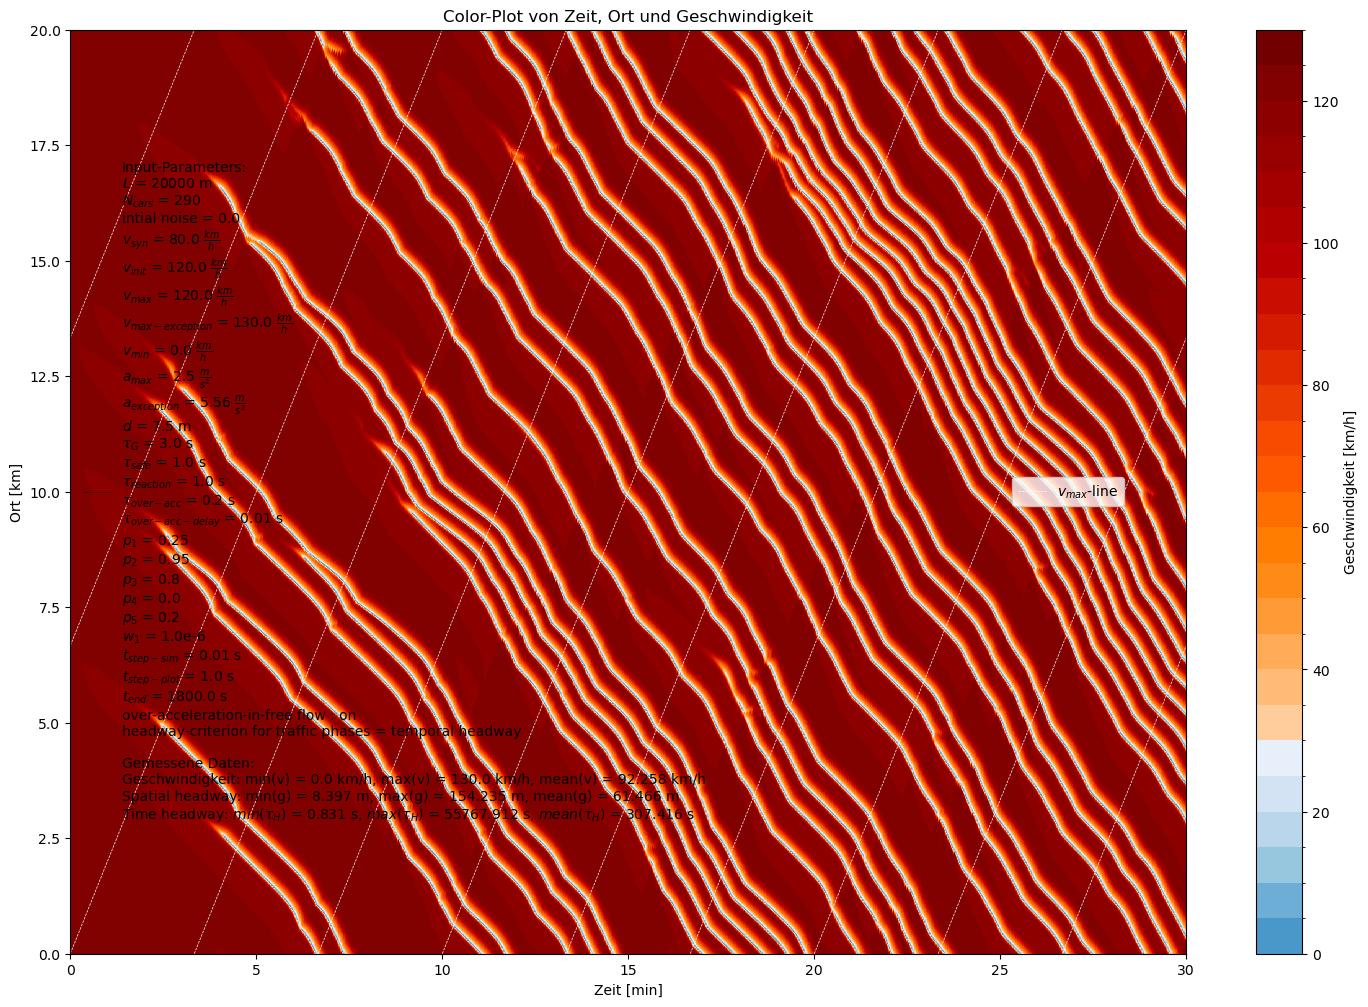

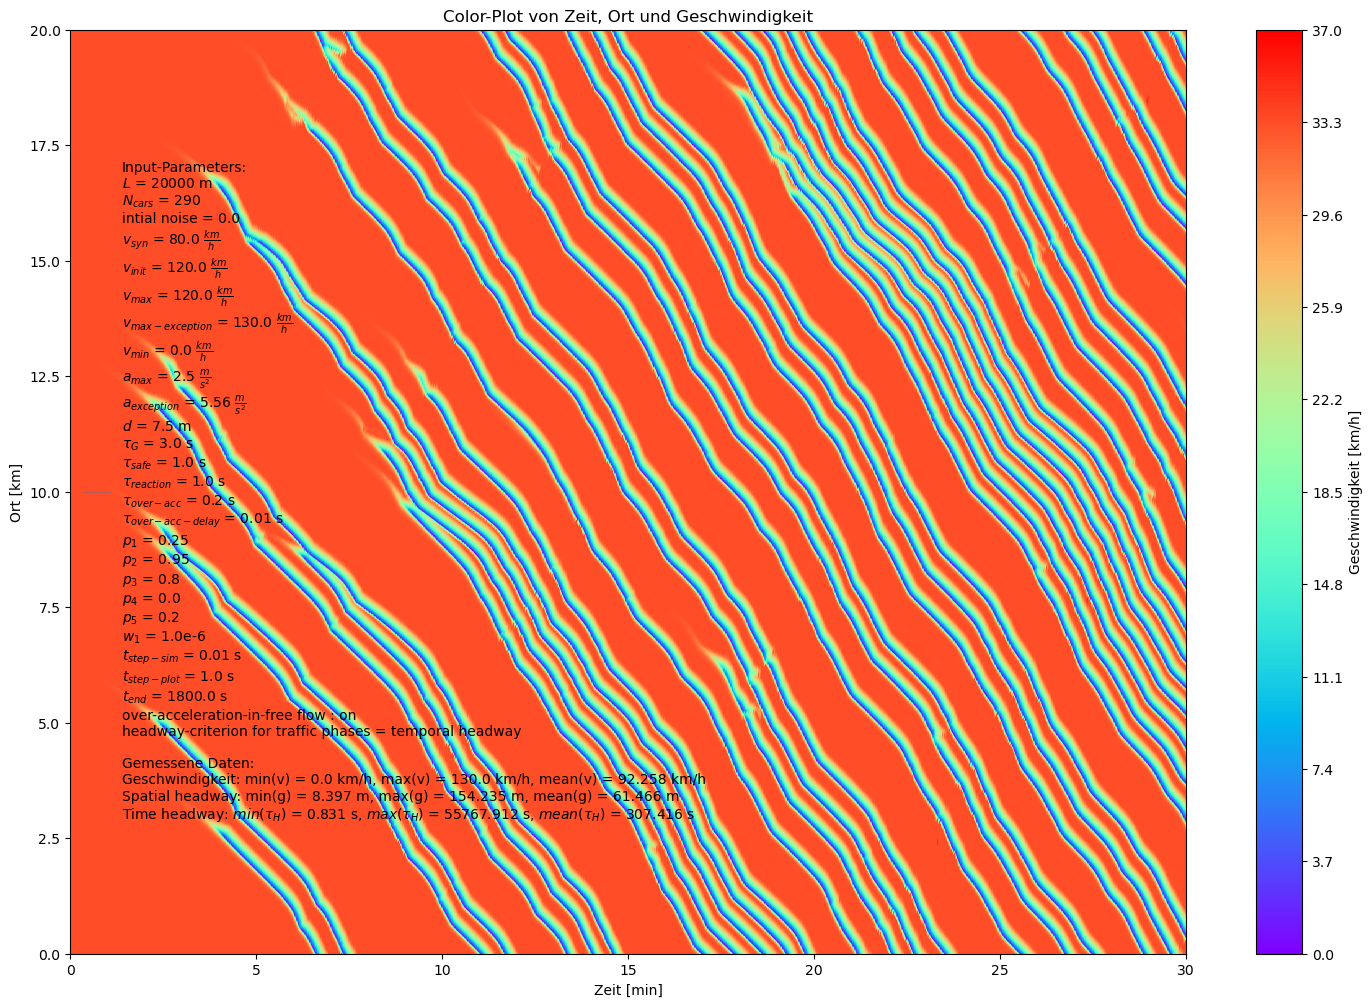

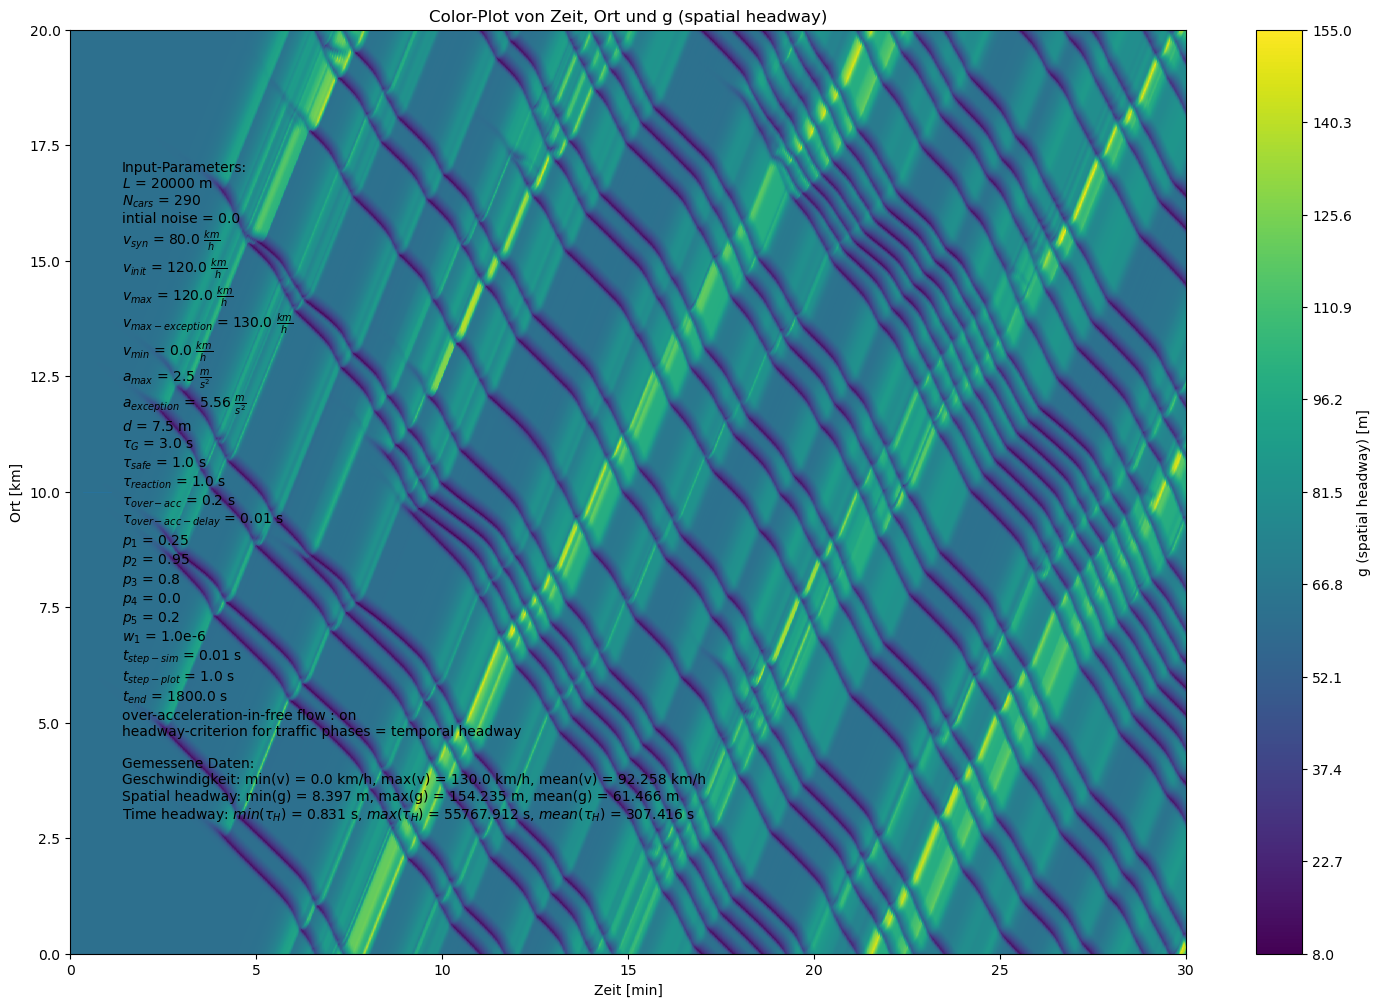

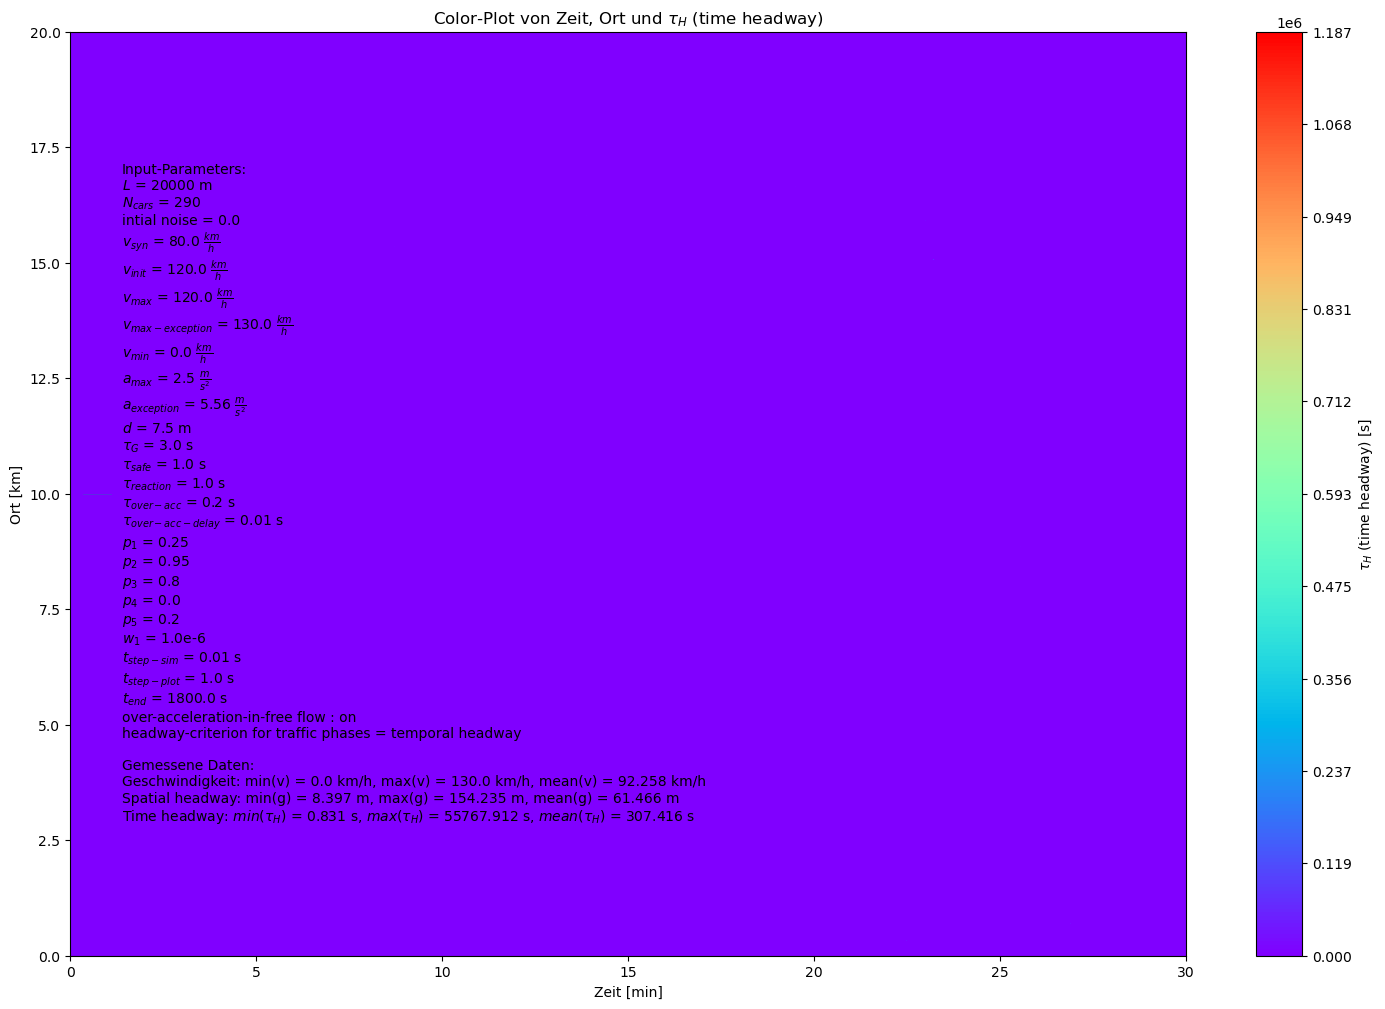

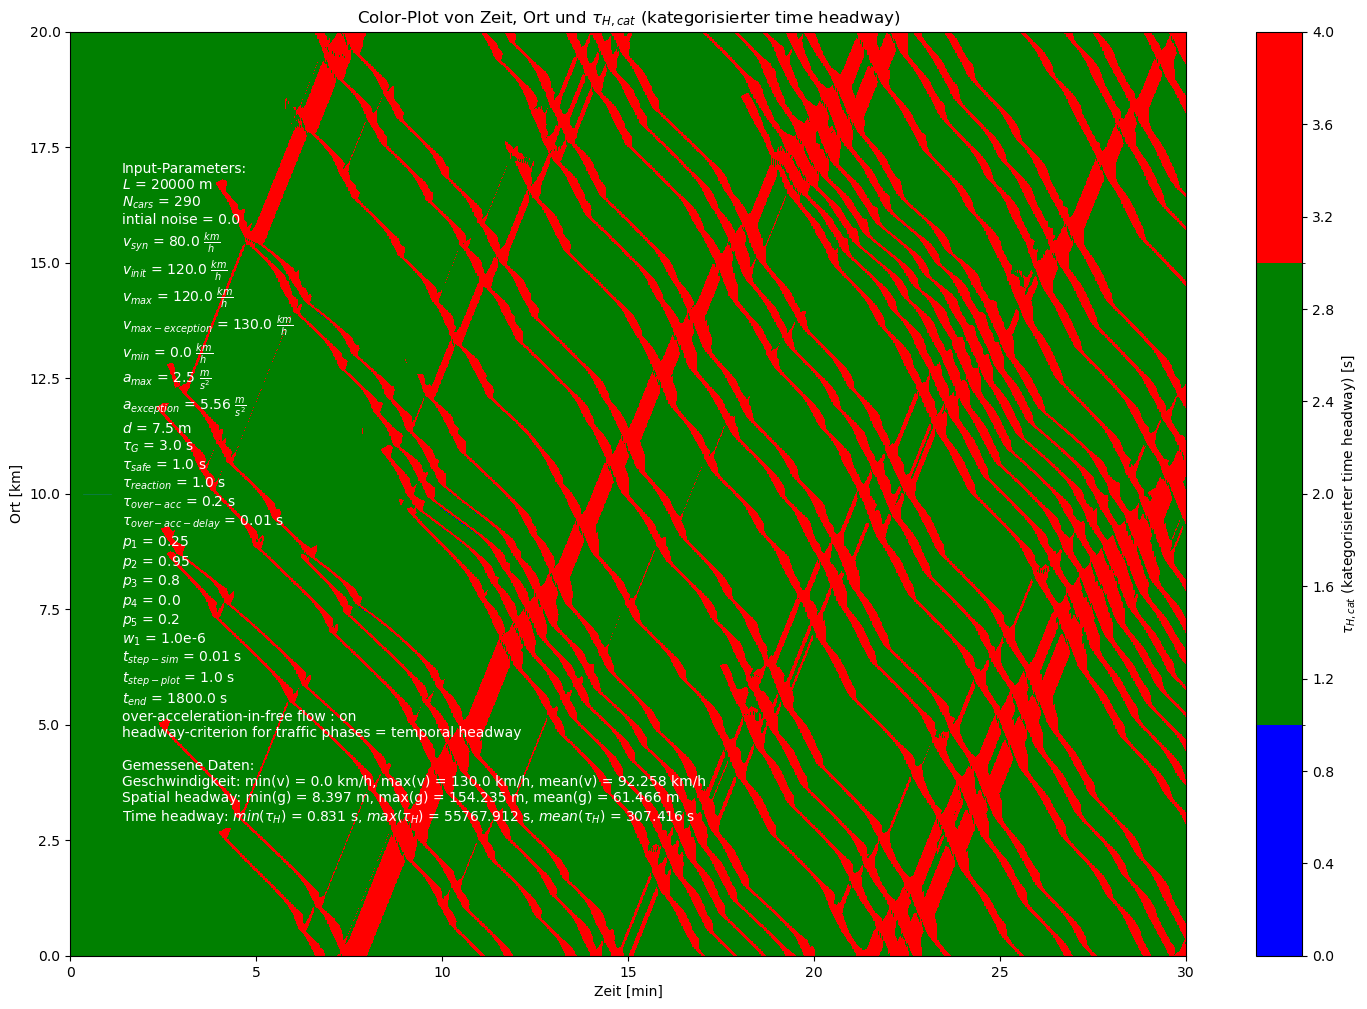

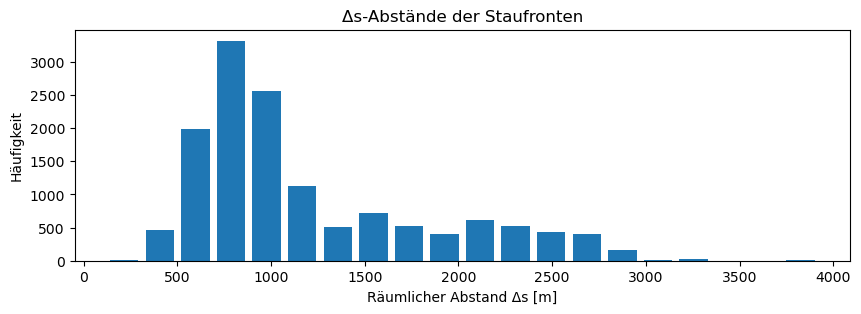

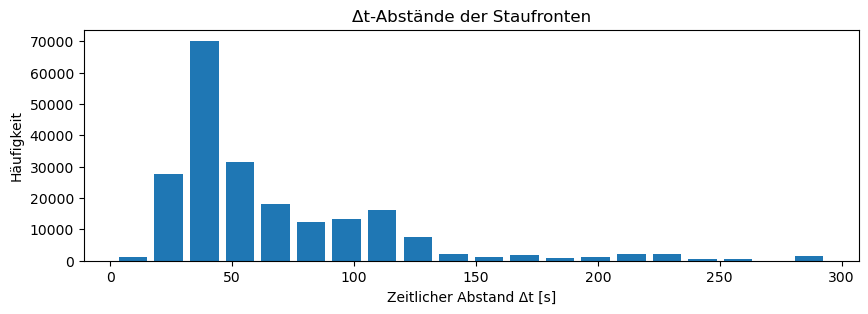

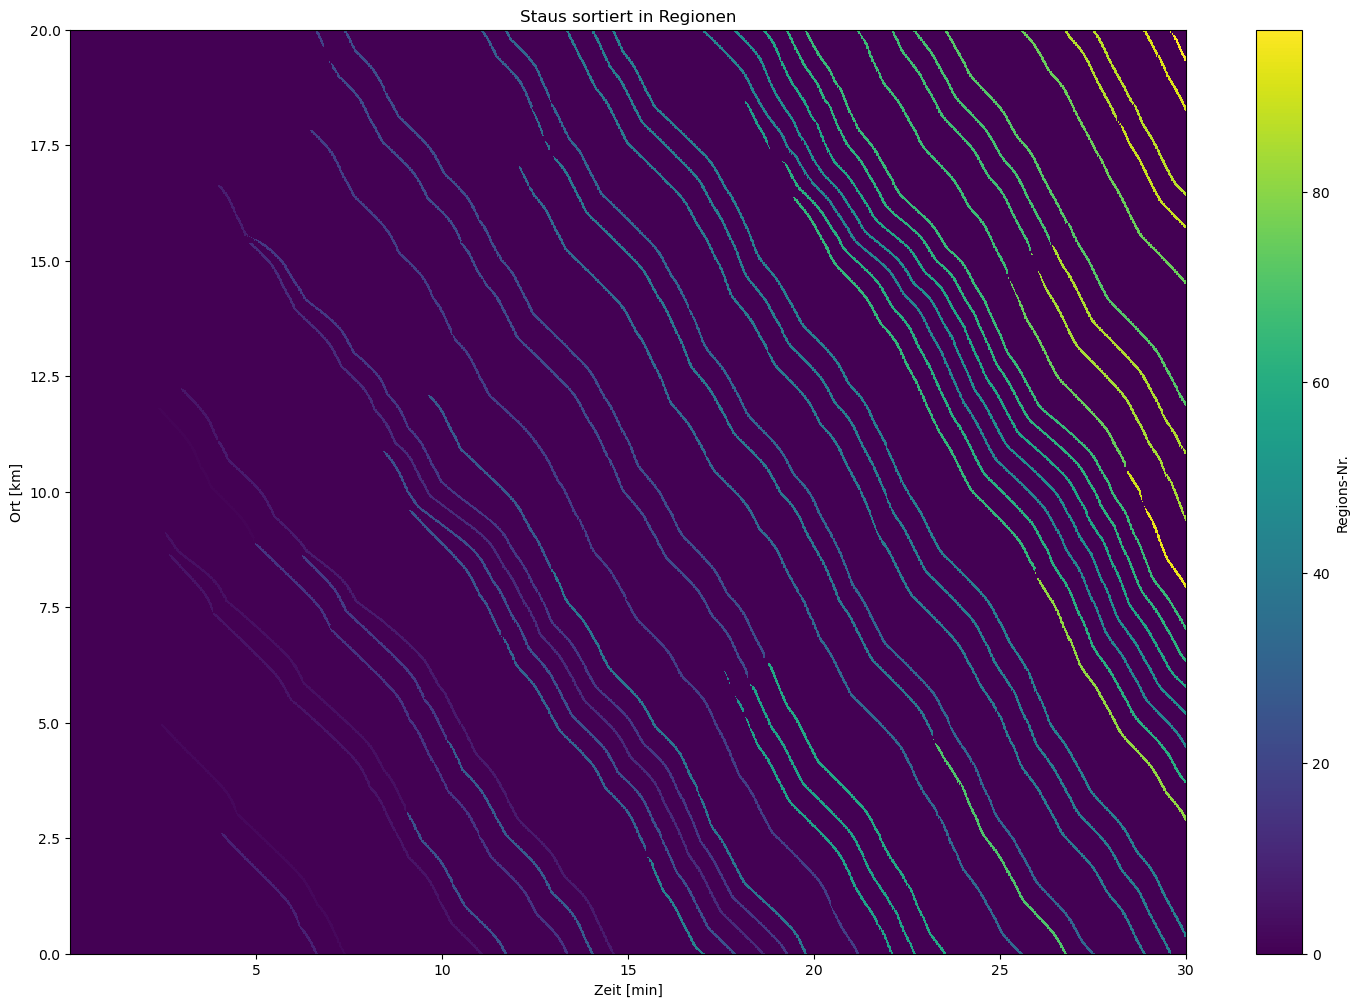

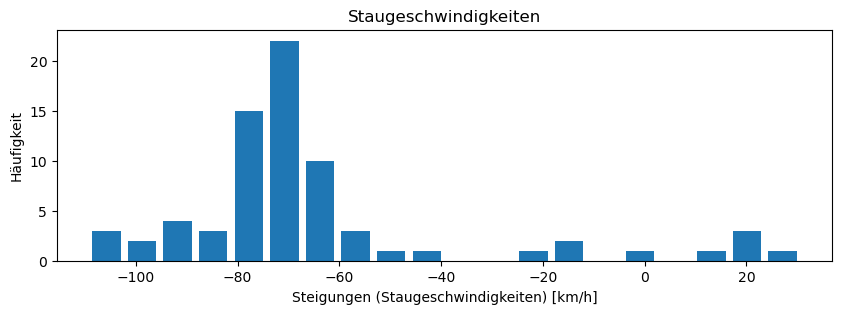

In [4]:
init_Startzeit = now()
println("init. Startzeit    = $init_Startzeit")

#include("Kerner 2023 period functions v8.txt")
############################################################################################################
### Input-variablen
############################################################################################################
npt = Dict(
    :L_track         => 2*10^4, #10*10^3,
    :N_cars          => 0, # nachbesetzen -------------------------------------------------------------------
    :init_noise      => 0.0, #0.25, #0.0
    :v_syn           => 22+2/9,
    :v_init          => 33+1/3, #22+2/9, #, #
    :v_max           => 33+1/3,
    :v_max_exception => 36+1/9, #38+8/9 m/s = 140 km/h , 36+1/9 m/s = 130 km/h
    :a_exception     => 5+5/9,  # -> 5+5/9 m/s^2 = 20 km/h/s
    :v_min           => 0.0, #-(8+1/3),
    :a_max           => 2.5,
    :d_par           => 7.5,
    :τ_G             => 3.0,
    :τ_safe          => 1.0,
    :τ_reaction      => 1.0, #0.7, #1.0, #1.2, #0.7, #0.6, #0.5, #1.0, #0.5, # 0.5
    :τ_over_acc      => 0.2, #1.0, #0.8, #0.6, #0.4, #0.2, #1.0, #1.0
    :τ_oa_delay      => 0.01, #1    
# für τ_H < τ_safe gilt: a = p1 * (g-g_safe) + p2 * (v_ln - v_n)
    :p1              => 0.25, #0.28, #0.35, #0.28, #0.25, #0.23, #0.2, #0.18, #0.17, #0.15, #0.25, #0.15,
    :p2              => 0.95, #0.95
# für τ_safe < τ_H < τ_G gilt: a = p3 * (v_ln - v_n) + p4 * Θ(v_n - v_syn)    
    :p3              => 0.8, #0.0
    :p4              => 0.0, #1.0
    :p5              => 0.0, # nachbesetzen in mainfunc -------------------------------------------------------
    :w1              => 0.0, # nachbesetzen in mainfunc -------------------------------------------------------
    :t_step_sim      => 0.01,
    :t_step_plot     => 1.0,
    :t_end           => 1800.0,
    
    :monitoring_oa_duration    => 60.0,
    :monitoring_oa_switch      => 0,
    :oa_in_fflow_switch        => 1,

    :acc_fct_nr      => 2 # 1 für spatial-headway , 2 für time-headway
)


N_cars_input_vec      = [290]
p5_input_in_vec       = [0.2]
w1_input_in_vec       = [1e-6]
τ_reaction_input_vec  = [1.0]

#########################################################################################
now_time = Dates.now()
# Datum- und Uhrzeitformat für den Dateinamen festlegen
date_time_format = DateFormat("yyyy-mm-dd_HH-MM-SS")
# Datum und Uhrzeit formatieren
date_time_string = Dates.format(now_time, date_time_format)

# Gib den Pfad zum neuen Ordner an
#ordner_pfad = "C:/Users/Fliese/Desktop/MA Stau/Sims/Kerner23 1lane zeitverzögert period/some images 3 - v-exceptions"*
#"/"*"Sim mit Verzögerung $date_time_string"
ordner_pfad = "./Sim $date_time_string"

pth = Dict(
    :o1 => ordner_pfad,
    :o2 => ordner_pfad*"/MSP - v in ts",
    :o3 => ordner_pfad*"/MSP - τH in ts",
    :o4 => ordner_pfad*"/MSP - τHcat in ts",
    :o5 => ordner_pfad*"/MSP - g in ts"
)
pth[:o1]
# Erstelle den neuen Ordner
mkdir(pth[:o1])
mkdir(pth[:o2])
mkdir(pth[:o3])
mkdir(pth[:o4])
mkdir(pth[:o5])
#########################################################################################
main_export = Dict{Symbol, Any}(
    :t_vec => [],
    :s_vec => [],
    :v_vec => [],
    :g_vec => []
)

# Teststring abspeichern
testy_string = "Test-string."
open(pth[:o1]*"/test_datei.txt", "w") do file
    write(file, testy_string)
end
########################################################################

number = 0
total_number = length(p5_input_in_vec) * length(w1_input_in_vec) * length(N_cars_input_vec) * length(τ_reaction_input_vec)
#println("p5_input_in_vec = $p5_input_in_vec, w1_input_in_vec = $w1_input_in_vec")
#println("total_number = $total_number")
min_v_kmh_vec  = []
max_v_kmh_vec  = []
mean_v_kmh_vec = []
min_g_vec      = []
min_τ_H_vec    = []

information_string = "Zusammenfassung\n"*"N_cars_input_vec = $N_cars_input_vec, "*
"p5_input_in_vec = $p5_input_in_vec , w1_input_in_vec = $w1_input_in_vec\n"

open(pth[:o1]*"/Zusammenfassung.txt", "w") do file2
    write(file2, information_string)
end

information_string2 = " "

for τ_reaction_input in τ_reaction_input_vec
    for N_cars_input in N_cars_input_vec
        for p5_input_in in p5_input_in_vec
            for w1_input_in in w1_input_in_vec
                number += 1
                println("\n\n"*"Simulation $number von $total_number: p5_input_in = $p5_input_in, "*
                    "w1_input_in = $w1_input_in")

                npt[:τ_reaction] = τ_reaction_input
                
                stats_on_gvτ_dict, exp_dictionary, param_string, stats_on_jams = Kerner2023main_func(
                    npt, pth, N_cars_input, p5_input_in, w1_input_in)
                
                push!(min_v_kmh_vec , stats_on_gvτ_dict[:min_v_kmh])
                push!(mean_v_kmh_vec , stats_on_gvτ_dict[:mean_v_kmh])
                push!(max_v_kmh_vec , stats_on_gvτ_dict[:max_v_kmh])
                push!(min_g_vec , stats_on_gvτ_dict[:min_g])
                push!(min_τ_H_vec , stats_on_gvτ_dict[:min_τ_H])
                
                information_string2 = "\nSimulation $number von $total_number:\n"*
                "N_cars = $N_cars_input, p5 = $p5_input_in , w1 = $w1_input_in\n"*
                param_string*"\n"*stats_on_jams[:report]*"\n"*"\n"
                
                open(pth[:o1]*"/Zusammenfassung.txt", "a") do file2
                    write(file2, information_string2)
                end
                
                println("stats_on_gvτ_dict = $stats_on_gvτ_dict")
                
                main_export[:t_vec]            = exp_dictionary[:t_vec]
                main_export[:s_vec]            = exp_dictionary[:s_vec]
                main_export[:v_vec]            = exp_dictionary[:v_vec]
                main_export[:g_vec]            = exp_dictionary[:g_vec]
                main_export[:param_string]     = exp_dictionary[:param_string]
                main_export[:p5_and_w1_string] = exp_dictionary[:p5_and_w1_string]
            end
        end
    end
end

###########################################################################
## Zusammenfassung in txt-Datei abspeichern
###################################################################
final_jetzt = now()
information_string3 = "\n"*"init_Startzeit = $init_Startzeit\n"*"final_jetzt    = $final_jetzt"
# Öffne die Datei im Schreibmodus und schreibe den String hinein
open(pth[:o1]*"/Zusammenfassung.txt", "a") do file2
    write(file2, information_string3)
end
#final_jetzt = now()
println("done - $final_jetzt")
println("minimum(v) = $(minimum(min_v_kmh_vec)) km/h")